In [ ]:
# !pip installs
!pip install scanpy anndata pandas pyreadr --quiet
!pip install scikit-misc --quiet
!pip install python-igraph leidenalg --quiet
!pip install matplotlib seaborn --quiet

In [ ]:
!pip install scvi-tools

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

root = "/content/drive/MyDrive"

folders = [
    d for d in os.listdir(root)
    if os.path.isdir(os.path.join(root, d))
]

print("Folders in MyDrive:")
for f in folders:
    print(" •", f)


Folders in MyDrive:
 • Colab Notebooks
 • data_science_final_project


In [ ]:
#read the file in

import os, gzip
from pathlib import Path

import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp

#Make data directory
pbmc_dir = Path("data/pbmc")
pbmc_dir.mkdir(parents=True, exist_ok=True)

# Make figure directory
FIG_DIR = "/content/drive/MyDrive/data_science_final_project/figures"
os.makedirs(FIG_DIR, exist_ok=True)

#Download RAW tar only once
if not (pbmc_dir / "GSE227835_RAW.tar").exists():
    !wget -O data/pbmc/GSE227835_RAW.tar \
      "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE227nnn/GSE227835/suppl/GSE227835_RAW.tar"

#Extract GSM*.txt.gz if not already extracted
if len(list(pbmc_dir.glob("GSM*.txt.gz"))) == 0:
    !tar -xvf data/pbmc/GSE227835_RAW.tar -C data/pbmc

#List all GSM files
files = sorted(pbmc_dir.glob("GSM*.txt.gz"))
print("Total GSM files:", len(files))
print("Example files:", [f.name for f in files[:6]])

Total GSM files: 40
Example files: ['GSM7266236_A1.txt.gz', 'GSM7266237_A10.txt.gz', 'GSM7266238_A2.txt.gz', 'GSM7266239_A3.txt.gz', 'GSM7266240_A4.txt.gz', 'GSM7266241_A5.txt.gz']


In [ ]:
#pick samples
healthy_files = [f for f in files if "_H" in f.name][:3]
achr_files    = [f for f in files if "_A" in f.name][:3]
sero_files    = [f for f in files if "_N" in f.name][:3]

subset_files = healthy_files + achr_files + sero_files
print("Using", len(subset_files), "files:")
for f in subset_files:
    print("  ", f.name)

Using 9 files:
   GSM7266246_H1.txt.gz
   GSM7266247_H10.txt.gz
   GSM7266248_H2.txt.gz
   GSM7266236_A1.txt.gz
   GSM7266237_A10.txt.gz
   GSM7266238_A2.txt.gz
   GSM7266256_N10a.txt.gz
   GSM7266257_N10b.txt.gz
   GSM7266258_N1a.txt.gz


In [ ]:
def read_gsm_file_sparse(path: Path, max_cells: int = 4000) -> sc.AnnData:
    """
    Read a single GSM*.txt.gz file as a sparse AnnData object.
    - Rows in file: genes
    - Columns: cell barcodes
    - We transpose to cells x genes.
    - We optionally subsample cells to max_cells per sample.
    """
    base = path.name.replace(".txt.gz", "")
    sample_id = base.split("_")[-1]

    #Condition code by naming convention: A = AChR+ MG, H = Healthy, N = Seronegative MG
    cond_code = sample_id[0]
    if cond_code == "A":
        condition = "AChR+ MG"
    elif cond_code == "H":
        condition = "Healthy"
    elif cond_code == "N":
        condition = "Seronegative MG"
    else:
        condition = "Unknown"

    print(f"Reading {path.name}  (sample {sample_id}, {condition})")

    #Read table
    with gzip.open(path, "rt") as f:
        df = pd.read_csv(f, sep="\t", index_col=0)
    df = df.T

    #subsampling of cells per donor
    if df.shape[0] > max_cells:
        df = df.sample(n=max_cells, random_state=0)

    #Build sparse matrix
    X = sp.csr_matrix(df.to_numpy(dtype=np.float32))

    #Build AnnData with obs/var
    ad = sc.AnnData(
        X=X,
        obs=pd.DataFrame(
            {
                "sample_id": sample_id,
                "condition": condition,
            },
            index=[f"{sample_id}_{c}" for c in df.index],
        ),
        var=pd.DataFrame(index=df.columns),
    )
    del df
    return ad


In [ ]:
#Read subset of GSM files

adatas = []
for f in subset_files:
    ad = read_gsm_file_sparse(f, max_cells=4000)
    adatas.append(ad)

len(adatas), adatas[0]

Reading GSM7266246_H1.txt.gz  (sample H1, Healthy)
Reading GSM7266247_H10.txt.gz  (sample H10, Healthy)
Reading GSM7266248_H2.txt.gz  (sample H2, Healthy)
Reading GSM7266236_A1.txt.gz  (sample A1, AChR+ MG)
Reading GSM7266237_A10.txt.gz  (sample A10, AChR+ MG)
Reading GSM7266238_A2.txt.gz  (sample A2, AChR+ MG)
Reading GSM7266256_N10a.txt.gz  (sample N10a, Seronegative MG)
Reading GSM7266257_N10b.txt.gz  (sample N10b, Seronegative MG)
Reading GSM7266258_N1a.txt.gz  (sample N1a, Seronegative MG)


(9,
 AnnData object with n_obs × n_vars = 4000 × 36601
     obs: 'sample_id', 'condition')

In [ ]:
#Concatenate all donors (inner gene intersection)

pbmc = sc.concat(
    adatas,
    join="outer",
    merge="unique",
    label="sample_id",
    keys=[a.obs["sample_id"].iloc[0] for a in adatas],
    index_unique=None,
)

print(pbmc)
print("Matrix type:", type(pbmc.X), "dtype:", pbmc.X.dtype)

#sanity: each (sample_id, condition) pair should be consistent
print(pbmc.obs.groupby(["sample_id", "condition"]).size())

AnnData object with n_obs × n_vars = 36000 × 36601
    obs: 'sample_id', 'condition'
Matrix type: <class 'scipy.sparse._csr.csr_matrix'> dtype: float32
sample_id  condition      
H1         AChR+ MG              0
           Healthy            4000
           Seronegative MG       0
H10        AChR+ MG              0
           Healthy            4000
           Seronegative MG       0
H2         AChR+ MG              0
           Healthy            4000
           Seronegative MG       0
A1         AChR+ MG           4000
           Healthy               0
           Seronegative MG       0
A10        AChR+ MG           4000
           Healthy               0
           Seronegative MG       0
A2         AChR+ MG           4000
           Healthy               0
           Seronegative MG       0
N10a       AChR+ MG              0
           Healthy               0
           Seronegative MG    4000
N10b       AChR+ MG              0
           Healthy               0
           Seron

/tmp/ipython-input-1471748552.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(pbmc.obs.groupby(["sample_id", "condition"]).size())


In [ ]:
print("PBMC RAW OBS COLUMNS:\n", pbmc.obs.columns.tolist())
print("\nPBMC RAW VAR COLUMNS:\n", pbmc.var.columns.tolist())
print("\nPBMC RAW OBS HEAD:")
print(pbmc.obs.head())
print("\nPBMC RAW VAR HEAD:")
print(pbmc.var.head())


PBMC RAW OBS COLUMNS:
 ['sample_id', 'condition']

PBMC RAW VAR COLUMNS:
 []

PBMC RAW OBS HEAD:
                      sample_id condition
H1_CTGCAGGGTTGCTTGA.1        H1   Healthy
H1_GCCAGTGCAATTCTCT.1        H1   Healthy
H1_TAAGCACGTTTCGACA.1        H1   Healthy
H1_TGCCGAGGTCCAAAGG.1        H1   Healthy
H1_CATACCCTCTCCATAT.1        H1   Healthy

PBMC RAW VAR HEAD:
Empty DataFrame
Columns: []
Index: [MIR1302-2HG, FAM138A, OR4F5, AL627309.1, AL627309.3]


In [ ]:
raw_dir = "/content/drive/MyDrive/data_science_final_project/raw_data"
os.makedirs(raw_dir, exist_ok=True)

raw_path = f"{raw_dir}/raw_PBMC.h5ad"

pbmc.write(raw_path)


✅ Saved RAW PBMC dataset to:
/content/drive/MyDrive/data_science_final_project/raw_data/raw_PBMC.h5ad


In [ ]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#--------------------------------------------------- can rerun from below if needed ---------------------------------------------------

In [ ]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
raw_path = "/content/drive/MyDrive/data_science_final_project/raw_data/raw_PBMC.h5ad"
pbmc = sc.read_h5ad(raw_path)

In [ ]:
print(pbmc)

AnnData object with n_obs × n_vars = 36000 × 36601
    obs: 'sample_id', 'condition'


In [ ]:
print("PBMC .obs columns:")
print(pbmc.obs.columns.tolist())

PBMC .obs columns:
['sample_id', 'condition']


In [ ]:
#Compute QC metrics + filter low-quality cells

#Identify mitochondrial genes (human convention: 'MT-')
pbmc.var["mt"] = pbmc.var_names.str.startswith("MT-")

#Compute QC metrics
sc.pp.calculate_qc_metrics(pbmc, qc_vars=["mt"], inplace=True)

# Filter cells
pbmc = pbmc[pbmc.obs["pct_counts_mt"] < 15, :]
pbmc = pbmc[pbmc.obs["n_genes_by_counts"] > 200, :]
pbmc = pbmc[pbmc.obs["n_genes_by_counts"] < 6000, :]
pbmc = pbmc[pbmc.obs["total_counts"] < 3e5, :]

#Filter genes: keep genes expressed in at least 10 cells
sc.pp.filter_genes(pbmc, min_cells=10)

print("---------------------------------")
print(pbmc)
print("---------------------------------")
print(pbmc.obs.columns.tolist())
print("---------------------------------")

/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


---------------------------------
AnnData object with n_obs × n_vars = 33615 × 21440
    obs: 'sample_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
---------------------------------
['sample_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt']
---------------------------------


In [ ]:
import os

root = "/content/drive/MyDrive/data_science_final_project"

for path, dirs, files in os.walk(root):
    print("PATH:", path)
    for d in dirs:
        print("  DIR:", d)
    for f in files:
        print("  FILE:", f)
    print("-" * 60)


PATH: /content/drive/MyDrive/data_science_final_project
  DIR: raw_data
  DIR: data_processed
  DIR: code
  DIR: figures
  DIR: metrics
  FILE: Final_project_report_paperFormat.gdoc
------------------------------------------------------------
PATH: /content/drive/MyDrive/data_science_final_project/raw_data
  FILE: healthy_thymus_epilethal.h5ad
  FILE: healthy_thymus_full.h5ad
  FILE: raw_PBMC.h5ad
------------------------------------------------------------
PATH: /content/drive/MyDrive/data_science_final_project/data_processed
  FILE: healthy_TEC_processed.h5ad
  FILE: dataset2_full.h5ad
  FILE: thymus_qc_raw (1).h5ad
  FILE: thymus_qc_hvg_lognorm.h5ad
  FILE: thymus_qc_hvg_lognorm_pca_umap_leiden.h5ad
  FILE: thymus_qc_raw.h5ad
  FILE: immune_combined_raw.h5ad
  FILE: scVI_metrics_python312_custom.csv
  FILE: immune_non_deep_HVG_union_raw.h5ad
  FILE: pbmc_qc.h5ad
  FILE: pbmc_DE_ready.h5ad
  FILE: pbmc_DE_annotated.h5ad
  FILE: pbmc_PCA_representation.h5ad
  FILE: pbmc_scVI_represent

In [ ]:
output_path = "/content/drive/MyDrive/data_science_final_project/data_processed/pbmc_qc.h5ad"
pbmc.write(output_path)

print("Saved PBMC QC dataset to:", output_path)

Saved PBMC QC dataset to: /content/drive/MyDrive/data_science_final_project/data_processed/pbmc_qc.h5ad


In [ ]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#--------------------------------------------------- can rerun from below if needed ---------------------------------------------------

In [ ]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
pbmc = sc.read_h5ad("/content/drive/MyDrive/data_science_final_project/data_processed/pbmc_qc.h5ad")
print(pbmc)
print("Loaded columns:", pbmc.obs.columns.tolist())

AnnData object with n_obs × n_vars = 33615 × 21440
    obs: 'sample_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
Loaded columns: ['sample_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt']


In [ ]:
print("---------------------------------")
print(pbmc)
print("---------------------------------")
print(pbmc.obs.columns.tolist())
print("---------------------------------")

---------------------------------
AnnData object with n_obs × n_vars = 33615 × 21440
    obs: 'sample_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
---------------------------------
['sample_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt']
---------------------------------


In [ ]:
#Normalize, log1p, HVG selection

#Normalize & log-transform
sc.pp.normalize_total(pbmc, target_sum=1e4)
sc.pp.log1p(pbmc)

In [ ]:

#Save processed PBMC
proc_dir = "/content/drive/MyDrive/data_science_final_project/data_processed"
os.makedirs(proc_dir, exist_ok=True)

proc_path = f"{proc_dir}/pbmc_normalized_log1p.h5ad"

pbmc.write(proc_path)

print(f"\Saved normalized/log1p PBMC dataset to:\n{proc_path}")



✅ Saved normalized/log1p PBMC dataset to:
/content/drive/MyDrive/data_science_final_project/data_processed/pbmc_normalized_log1p.h5ad


In [ ]:
print("---------------------------------")
print(pbmc)
print("---------------------------------")
print(pbmc.obs.columns.tolist())
print("---------------------------------")

---------------------------------
AnnData object with n_obs × n_vars = 33615 × 21440
    obs: 'sample_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p'
---------------------------------
['sample_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt']
---------------------------------


In [ ]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#--------------------------------------------------- can rerun from below if needed ---------------------------------------------------

In [ ]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
proc_path = "/content/drive/MyDrive/data_science_final_project/data_processed/pbmc_normalized_log1p.h5ad"

pbmc = sc.read_h5ad(proc_path)

print("Loaded processed PBMC AnnData object:")
print(pbmc)

Loaded processed PBMC AnnData object:
AnnData object with n_obs × n_vars = 33615 × 21440
    obs: 'sample_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p'


In [ ]:
#create a clean SCVI copy BEFORE scaling
pbmc_scvi = pbmc.copy()

In [ ]:
# Save DE-READY PBMC Object (log-normalized, unscaled)

# Create DE-ready copy BEFORE scaling
pbmc_de = pbmc.copy()

# Save to your project directory
pbmc_de_path = "/content/drive/MyDrive/data_science_final_project/data_processed/pbmc_DE_ready.h5ad"
pbmc_de.write(pbmc_de_path)

print("Saved DE-ready PBMC object to:", pbmc_de_path)

Saved DE-ready PBMC object to: /content/drive/MyDrive/data_science_final_project/data_processed/pbmc_DE_ready.h5ad


In [ ]:
#Highly variable genes, accounting for batch (sample_id)
sc.pp.highly_variable_genes(
    pbmc,
    n_top_genes=2000,
    flavor="seurat_v3",
    batch_key="sample_id",
)

print("Number of HVGs:", pbmc.var["highly_variable"].sum())

#Subset to HVGs
pbmc = pbmc[:, pbmc.var["highly_variable"]].copy()
print("After HVG selection:", pbmc)

/usr/local/lib/python3.12/dist-packages/legacy_api_wrap/__init__.py:88: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


Number of HVGs: 2000
After HVG selection: AnnData object with n_obs × n_vars = 33615 × 2000
    obs: 'sample_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg'


In [ ]:
# Save HVG-filtered PBMC
proc_dir = "/content/drive/MyDrive/data_science_final_project/data_processed"
os.makedirs(proc_dir, exist_ok=True)

hvg_path = f"{proc_dir}/pbmc_HVG_2000.h5ad"

pbmc.write(hvg_path)

print(f"\n Saved HVG-filtered PBMC dataset to:\n{hvg_path}")


✅ Saved HVG-filtered PBMC dataset to:
/content/drive/MyDrive/data_science_final_project/data_processed/pbmc_HVG_2000.h5ad


In [ ]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#--------------------------------------------------- can rerun from below if needed ---------------------------------------------------

In [ ]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# -----------------------------------
# 3. Reload into `pbmc`
# -----------------------------------
pbmc = sc.read_h5ad(hvg_path)

print("\n Reloaded PBMC HVG AnnData object:")
print(pbmc)


🔄 Reloaded PBMC HVG AnnData object:
AnnData object with n_obs × n_vars = 33615 × 2000
    obs: 'sample_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', 'log1p'


/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


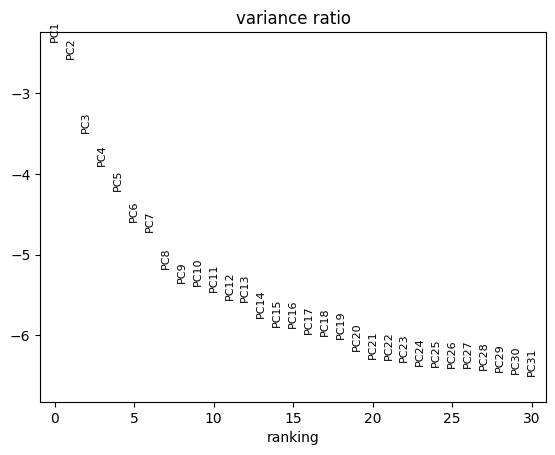

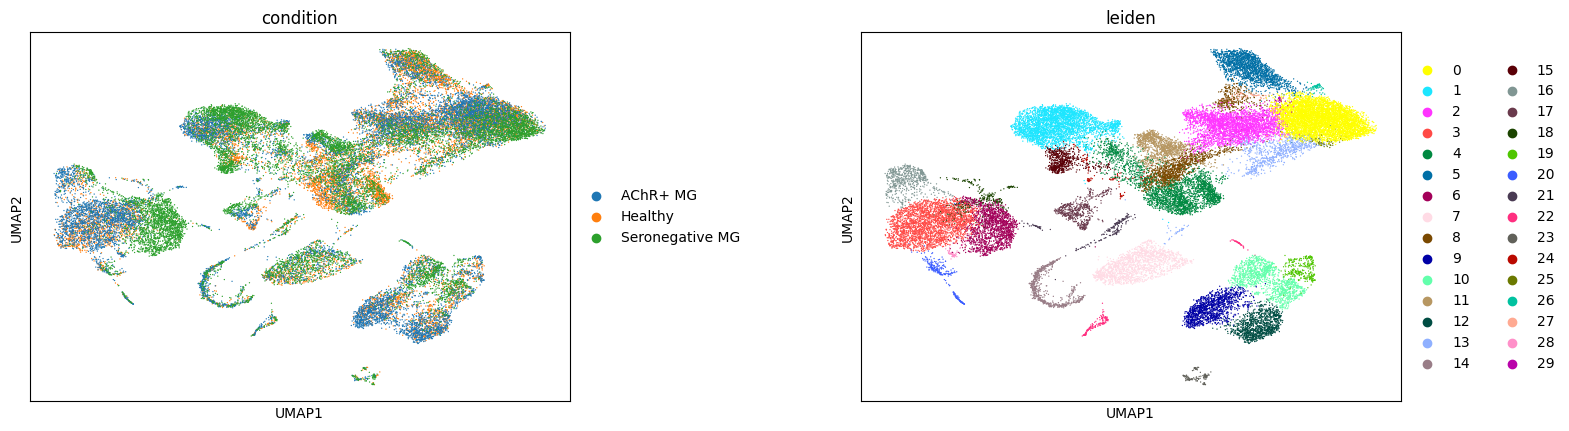

In [ ]:
#Scale, PCA, neighbors, UMAP, Leiden ====

#Scale
sc.pp.scale(pbmc, max_value=10)

#PCA
sc.tl.pca(pbmc, n_comps=50)
sc.pl.pca_variance_ratio(pbmc, log=True)

#Neighbors + UMAP
sc.pp.neighbors(pbmc, n_neighbors=15, n_pcs=30)
sc.tl.umap(pbmc)

#Leiden clustering (you can tune resolution)
sc.tl.leiden(pbmc, resolution=1.0, key_added="leiden")

sc.pl.umap(pbmc, color=["condition", "leiden"], wspace=0.4)

In [ ]:
#SAVE PCA-BASED PBMC OBJECT (needed later for metrics)
pca_path = "/content/drive/MyDrive/data_science_final_project/data_processed/pbmc_PCA_representation.h5ad"
pbmc.write(pca_path)
print("Saved PCA-based PBMC object to:", pca_path)

Saved PCA-based PBMC object to: /content/drive/MyDrive/data_science_final_project/data_processed/pbmc_PCA_representation.h5ad


In [ ]:
print("---------------------------------")
print(pbmc)
print("---------------------------------")
print(pbmc.obs.columns.tolist())
print("---------------------------------")

---------------------------------
AnnData object with n_obs × n_vars = 33615 × 2000
    obs: 'sample_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'condition_colors', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
---------------------------------
['sample_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', '

In [ ]:
"cell_type" in pbmc.obs.columns

False

In [ ]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#--------------------------------------------------- can rerun from below if needed ---------------------------------------------------

In [ ]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
import scanpy as sc

pca_path = "/content/drive/MyDrive/data_science_final_project/data_processed/pbmc_PCA_representation.h5ad"

pbmc = sc.read_h5ad(pca_path)

print("Loaded PCA-based PBMC AnnData object:")
print(pbmc)


Loaded PCA-based PBMC AnnData object:
AnnData object with n_obs × n_vars = 33615 × 2000
    obs: 'sample_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'condition_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


In [ ]:
#Marker scores + per-cell annotation + cluster-level annotation

marker_dict = {
    "CD4 T"        : ["CD3E", "IL7R", "CCR7", "LTB"],
    "Cytotoxic T"  : ["CD3D", "NKG7", "GZMB", "GNLY", "PRF1"],
    "B"            : ["MS4A1", "CD79A", "CD79B"],
    "Mono (CD14)"  : ["LYZ", "S100A8", "S100A9", "CTSS"],
    "Mono (FCGR3A)": ["FCGR3A", "MS4A7", "LYZ"],
    "DC"           : ["FCER1A", "CST3"],
    "Platelet"     : ["PPBP", "PF4"],
}

#Filter marker genes to those present in HVGs
marker_dict_filtered = {}
for ct, genes in marker_dict.items():
    present = [g for g in genes if g in pbmc.var_names]
    if len(present) == 0:
        print(f"WARNING: no markers for {ct} in HVGs, skipping.")
        continue
    marker_dict_filtered[ct] = present

print("Filtered marker sets:", marker_dict_filtered)

#Gene-set scores per cell
for ct, genes in marker_dict_filtered.items():
    sc.tl.score_genes(
        pbmc,
        gene_list=genes,
        score_name=f"{ct}_score",
        use_raw=False
    )

#per cell annotation (fixes purity issue)

score_cols = [f"{ct}_score" for ct in marker_dict_filtered.keys()]

#For each cell, pick the highest-scoring cell type
pbmc.obs["cell_type"] = (
    pbmc.obs[score_cols]
    .idxmax(axis=1)
    .str.replace("_score", "", regex=False)
)

print("\nPer-cell annotation complete:")
print(pbmc.obs["cell_type"].value_counts())

#cluster level labels

cluster_labels = (
    pbmc.obs.groupby("leiden")["cell_type"]
    .agg(lambda x: x.value_counts().index[0])
)

pbmc.obs["cluster_celltype"] = pbmc.obs["leiden"].map(cluster_labels)

print("\nCluster-level annotation (majority vote):")
print(cluster_labels)


# SAVE UPDATED PCA OBJECT WITH ANNOTATION
pca_path = "/content/drive/MyDrive/data_science_final_project/data_processed/pbmc_PCA_annotated.h5ad"

pbmc.write(pca_path)

print("✓ Updated PCA object saved with cell_type + cluster_celltype:")
print("Saved to:", pca_path)


Filtered marker sets: {'CD4 T': ['IL7R', 'LTB'], 'Cytotoxic T': ['CD3D', 'NKG7', 'GZMB', 'GNLY', 'PRF1'], 'B': ['MS4A1', 'CD79A', 'CD79B'], 'Mono (CD14)': ['LYZ', 'S100A8', 'S100A9', 'CTSS'], 'Mono (FCGR3A)': ['FCGR3A', 'MS4A7', 'LYZ'], 'DC': ['FCER1A', 'CST3'], 'Platelet': ['PPBP', 'PF4']}

Per-cell annotation complete:
cell_type
CD4 T            12626
Cytotoxic T       6921
Mono (CD14)       4856
B                 4224
Platelet          3338
Mono (FCGR3A)     1085
DC                 565
Name: count, dtype: int64

Cluster-level annotation (majority vote):
leiden
0             CD4 T
1       Cytotoxic T
2             CD4 T
3       Mono (CD14)
4       Cytotoxic T
5             CD4 T
6       Mono (CD14)
7          Platelet
8             CD4 T
9                 B
10                B
11            CD4 T
12                B
13         Platelet
14         Platelet
15      Cytotoxic T
16    Mono (FCGR3A)
17      Mono (CD14)
18      Mono (CD14)
19                B
20               DC
21        

/tmp/ipython-input-1985725158.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pbmc.obs.groupby("leiden")["cell_type"]


✓ Updated PCA object saved with cell_type + cluster_celltype:
Saved to: /content/drive/MyDrive/data_science_final_project/data_processed/pbmc_PCA_annotated.h5ad


In [ ]:
print("---------------------------------")
print(pbmc)
print("---------------------------------")
print(pbmc.obs.columns.tolist())
print("---------------------------------")

---------------------------------
AnnData object with n_obs × n_vars = 33615 × 2000
    obs: 'sample_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'leiden', 'CD4 T_score', 'Cytotoxic T_score', 'B_score', 'Mono (CD14)_score', 'Mono (FCGR3A)_score', 'DC_score', 'Platelet_score', 'cell_type', 'cluster_celltype'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'condition_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'dista

In [ ]:
print("CHECK — does cell_type exist?", "cell_type" in pbmc.obs.columns)
print(pbmc.obs.columns.tolist())

CHECK — does cell_type exist? True
['sample_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'leiden', 'CD4 T_score', 'Cytotoxic T_score', 'B_score', 'Mono (CD14)_score', 'Mono (FCGR3A)_score', 'DC_score', 'Platelet_score', 'cell_type', 'cluster_celltype']


In [ ]:
print("CHECK — does cell_type exist?", "cluster_celltype" in pbmc.obs.columns)
print(pbmc.obs.columns.tolist())

CHECK — does cell_type exist? True
['sample_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'leiden', 'CD4 T_score', 'Cytotoxic T_score', 'B_score', 'Mono (CD14)_score', 'Mono (FCGR3A)_score', 'DC_score', 'Platelet_score', 'cell_type', 'cluster_celltype']


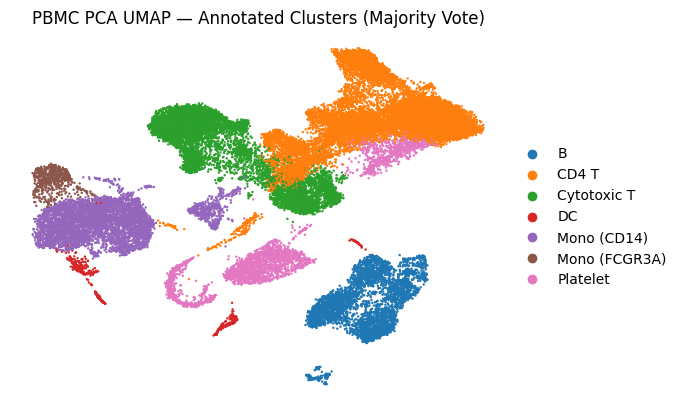

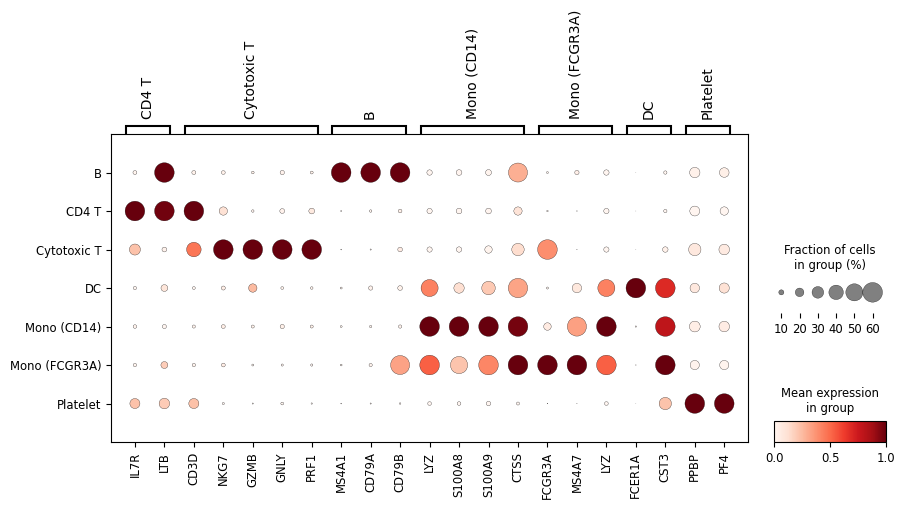

In [ ]:
#UMAP
import matplotlib.pyplot as plt
import seaborn as sns

unique_ct = pbmc.obs["cluster_celltype"].unique().tolist()
palette = sns.color_palette("tab10", n_colors=len(unique_ct))

ct_color_map = {ct: palette[i] for i, ct in enumerate(unique_ct)}
pbmc.uns["cluster_celltype_colors"] = [ct_color_map[ct] for ct in pbmc.obs["cluster_celltype"]]

sc.pl.umap(
    pbmc,
    color=["cluster_celltype"],   # <--- uses cluster labels for UMAP aesthetic
    frameon=False,
    size=12,
    legend_fontsize=10,
    legend_loc="right margin",
    title="PBMC PCA UMAP — Annotated Clusters (Majority Vote)",
    palette=palette,
    save=False
)

#Dotplot
sc.pl.dotplot(
    pbmc,
    marker_dict_filtered,
    groupby="cluster_celltype",
    dendrogram=False,
    figsize=(10,4),
    dot_max=0.6,
    standard_scale="var",
    show=True
)


In [ ]:
# SAVE PCA-ANNOTATED PBMC OBJECT

annotated_pca_path = (
    "/content/drive/MyDrive/data_science_final_project/data_processed/pbmc_PCA_annotated.h5ad"
)

pbmc.write(annotated_pca_path)

print("✓ Saved annotated PCA-based PBMC object to:")
print(annotated_pca_path)

# Quick sanity check
print("Annotated PCA object obs columns:")
print(pbmc.obs.columns.tolist())


✓ Saved annotated PCA-based PBMC object to:
/content/drive/MyDrive/data_science_final_project/data_processed/pbmc_PCA_annotated.h5ad
Annotated PCA object obs columns:
['sample_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'leiden', 'CD4 T_score', 'Cytotoxic T_score', 'B_score', 'Mono (CD14)_score', 'Mono (FCGR3A)_score', 'DC_score', 'Platelet_score', 'cell_type', 'cluster_celltype']


In [ ]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#--------------------------------------------------- can rerun from below if needed ---------------------------------------------------

In [ ]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
pca_path = "/content/drive/MyDrive/data_science_final_project/data_processed/pbmc_PCA_annotated.h5ad"

pbmc = sc.read_h5ad(pca_path)

Figures will be saved to: /content/drive/MyDrive/data_science_final_project/figures


/tmp/ipython-input-3699378491.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["condition", "cell_type"])
/tmp/ipython-input-3699378491.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comp_df["total_cells"] = comp_df.groupby("condition")["count"].transform("sum")


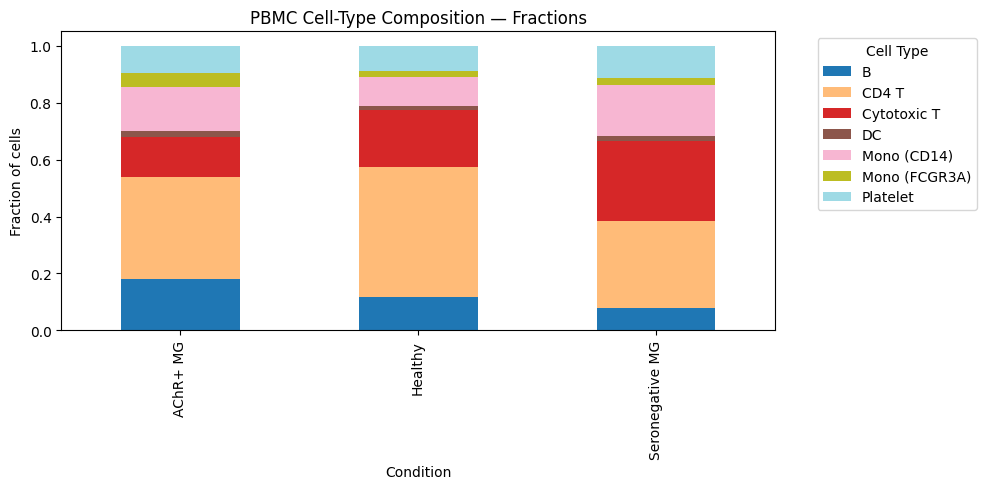

Saved: /content/drive/MyDrive/data_science_final_project/figures/pbmc_composition_fractions.png
Saved: /content/drive/MyDrive/data_science_final_project/figures/pbmc_composition_fractions.pdf


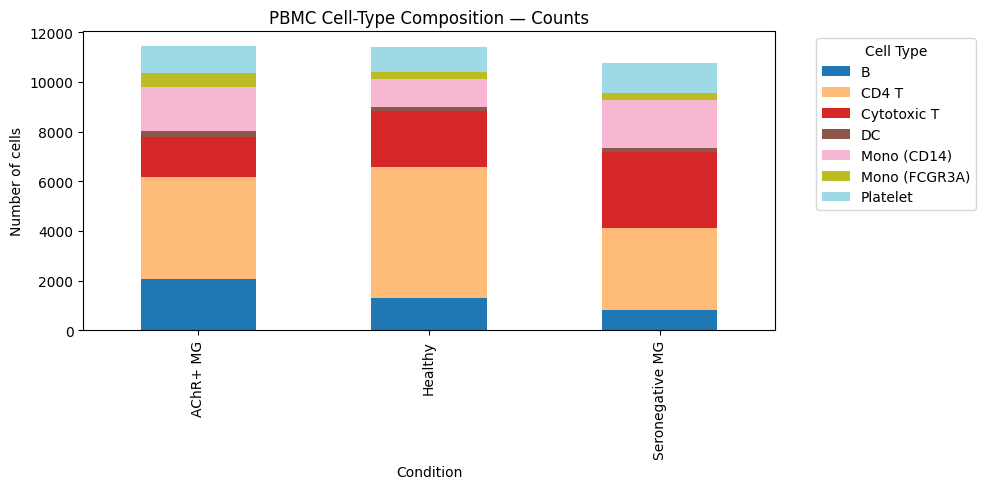

Saved: /content/drive/MyDrive/data_science_final_project/figures/pbmc_composition_counts.png
Saved: /content/drive/MyDrive/data_science_final_project/figures/pbmc_composition_counts.pdf


In [ ]:
#PMBC compositional analysis

import pandas as pd
import matplotlib.pyplot as plt
import os

#ensure figure directory exists and is correct
FIG_DIR = "/content/drive/MyDrive/data_science_final_project/figures"
os.makedirs(FIG_DIR, exist_ok=True)
print("Figures will be saved to:", FIG_DIR)


#Compute counts per (condition, cell_type)
comp_df = (
    pbmc.obs
        .groupby(["condition", "cell_type"])
        .size()
        .reset_index(name="count")
)

#Add total cells per condition and compute fractions
comp_df["total_cells"] = comp_df.groupby("condition")["count"].transform("sum")
comp_df["fraction"] = comp_df["count"] / comp_df["total_cells"]


#fraction plot
pivot_frac = comp_df.pivot(index="condition", columns="cell_type", values="fraction")

fig, ax = plt.subplots(figsize=(10, 5))
pivot_frac.plot(kind="bar", stacked=True, ax=ax, colormap="tab20")

ax.set_ylabel("Fraction of cells")
ax.set_xlabel("Condition")
ax.set_title("PBMC Cell-Type Composition — Fractions")
ax.legend(title="Cell Type", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()

#Display in notebook
plt.show()

#Save
frac_png = f"{FIG_DIR}/pbmc_composition_fractions.png"
frac_pdf = f"{FIG_DIR}/pbmc_composition_fractions.pdf"

fig.savefig(frac_png, dpi=300, bbox_inches="tight")
fig.savefig(frac_pdf, dpi=300, bbox_inches="tight")

print("Saved:", frac_png)
print("Saved:", frac_pdf)

plt.close(fig)

#Count plot
pivot_count = comp_df.pivot(index="condition", columns="cell_type", values="count")

fig, ax = plt.subplots(figsize=(10, 5))
pivot_count.plot(kind="bar", stacked=True, ax=ax, colormap="tab20")

ax.set_ylabel("Number of cells")
ax.set_xlabel("Condition")
ax.set_title("PBMC Cell-Type Composition — Counts")
ax.legend(title="Cell Type", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()

#shw in notebook
plt.show()

#save
count_png = f"{FIG_DIR}/pbmc_composition_counts.png"
count_pdf = f"{FIG_DIR}/pbmc_composition_counts.pdf"

fig.savefig(count_png, dpi=300, bbox_inches="tight")
fig.savefig(count_pdf, dpi=300, bbox_inches="tight")

print("Saved:", count_png)
print("Saved:", count_pdf)

plt.close(fig)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Counts and fractions per (condition, cell_type)
comp = (
    pbmc.obs
        .groupby(['condition', 'cell_type'])
        .size()
        .reset_index(name='n_cells')
)

# Add total cells per condition and fractions
comp['total_cells'] = comp.groupby('condition')['n_cells'].transform('sum')
comp['fraction'] = comp['n_cells'] / comp['total_cells']

comp


/tmp/ipython-input-4095955365.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['condition', 'cell_type'])
/tmp/ipython-input-4095955365.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comp['total_cells'] = comp.groupby('condition')['n_cells'].transform('sum')


condition      cell_type  n_cells  total_cells  fraction
0          AChR+ MG              B     2060        11456  0.179818
1          AChR+ MG          CD4 T     4115        11456  0.359200
2          AChR+ MG    Cytotoxic T     1591        11456  0.138879
3          AChR+ MG             DC      240        11456  0.020950
4          AChR+ MG    Mono (CD14)     1787        11456  0.155988
5          AChR+ MG  Mono (FCGR3A)      560        11456  0.048883
6          AChR+ MG       Platelet     1103        11456  0.096281
7           Healthy              B     1321        11401  0.115867
8           Healthy          CD4 T     5233        11401  0.458995
9           Healthy    Cytotoxic T     2280        11401  0.199982
10          Healthy             DC      168        11401  0.014736
11          Healthy    Mono (CD14)     1122        11401  0.098412
12          Healthy  Mono (FCGR3A)      252        11401  0.022103
13          Healthy       Platelet     1025        11401  0.089904
14  Seronegative MG              B      843        10758  0.078360
15  Seronegative MG          CD4 T     3278        10758  0.304703
16  Seronegative MG    Cytotoxic T     3050        10758  0.283510
17  Seronegative MG             DC      157        10758  0.014594
18  Seronegative MG    Mono (CD14)     1947        10758  0.180982
19  Seronegative MG  Mono (FCGR3A)      273        10758  0.025376
20  Seronegative MG       Platelet     1210        10758  0.112474

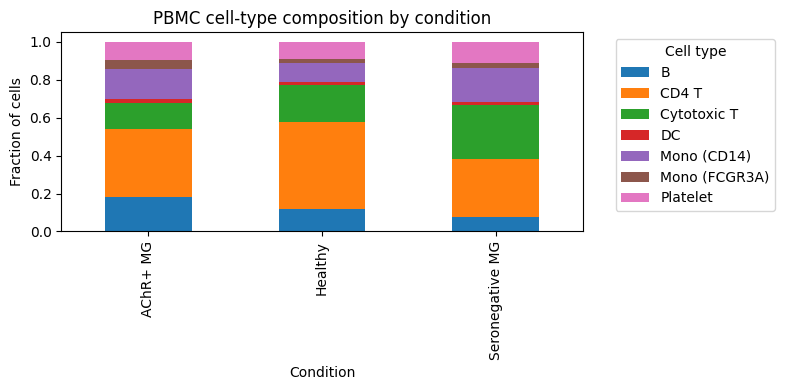

In [ ]:
# Pivot to condition x cell_type table of fractions
fractions = comp.pivot(index='condition',
                       columns='cell_type',
                       values='fraction')

# Make a nice stacked barplot
ax = fractions.plot(kind='bar',
                    stacked=True,
                    figsize=(8,4))

ax.set_ylabel("Fraction of cells")
ax.set_xlabel("Condition")
ax.set_title("PBMC cell-type composition by condition")
plt.legend(title="Cell type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#--------------------------------------------------- can rerun from below if needed ---------------------------------------------------

In [ ]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pbmc_de_path = "/content/drive/MyDrive/data_science_final_project/data_processed/pbmc_DE_ready.h5ad"
pbmc_de = sc.read_h5ad(pbmc_de_path)

print(pbmc_de)
print(pbmc_de.obs["condition"].value_counts())

AnnData object with n_obs × n_vars = 33615 × 21440
    obs: 'sample_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p'
condition
AChR+ MG           11456
Healthy            11401
Seronegative MG    10758
Name: count, dtype: int64


In [ ]:
marker_dict_filtered = {}
for ct, genes in marker_dict.items():
    present = [g for g in genes if g in pbmc_de.var_names]
    if present:
        marker_dict_filtered[ct] = present
    else:
        print(f"WARNING: no markers found for {ct}")

print("Filtered marker sets:", marker_dict_filtered)


Filtered marker sets: {'CD4 T': ['CD3E', 'IL7R', 'CCR7', 'LTB'], 'Cytotoxic T': ['CD3D', 'NKG7', 'GZMB', 'GNLY', 'PRF1'], 'B': ['MS4A1', 'CD79A', 'CD79B'], 'Mono (CD14)': ['LYZ', 'S100A8', 'S100A9', 'CTSS'], 'Mono (FCGR3A)': ['FCGR3A', 'MS4A7', 'LYZ'], 'DC': ['FCER1A', 'CST3'], 'Platelet': ['PPBP', 'PF4']}


In [ ]:
for ct, genes in marker_dict_filtered.items():
    sc.tl.score_genes(
        pbmc_de,
        gene_list=genes,
        score_name=f"{ct}_score",
        use_raw=False
    )


In [ ]:
score_cols = [f"{ct}_score" for ct in marker_dict_filtered.keys()]

pbmc_de.obs["cell_type"] = (
    pbmc_de.obs[score_cols]
    .idxmax(axis=1)
    .str.replace("_score", "", regex=False)
)


In [ ]:
sc.pp.neighbors(pbmc_de, n_neighbors=15)
sc.tl.leiden(pbmc_de, resolution=1.0)


/usr/local/lib/python3.12/dist-packages/scanpy/neighbors/__init__.py:577: UserWarning: You’re trying to run this on 21440 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  x = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)


In [ ]:
cluster_labels = (
    pbmc_de.obs.groupby("leiden")["cell_type"]
    .agg(lambda x: x.value_counts().index[0])
)
pbmc_de.obs["cluster_celltype"] = pbmc_de.obs["leiden"].map(cluster_labels)


/tmp/ipython-input-455659828.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pbmc_de.obs.groupby("leiden")["cell_type"]


In [ ]:
print(pbmc_de.obs["cell_type"].value_counts())
print(pbmc_de.obs["cluster_celltype"].value_counts())


cell_type
CD4 T            13166
Cytotoxic T       7117
Mono (CD14)       5510
B                 4082
Platelet          2808
Mono (FCGR3A)      545
DC                 387
Name: count, dtype: int64
cluster_celltype
CD4 T            13474
Cytotoxic T       7643
Mono (CD14)       5215
B                 4118
Platelet          2145
Mono (FCGR3A)      581
DC                 439
Name: count, dtype: int64


In [ ]:
print(pbmc_de)


AnnData object with n_obs × n_vars = 33615 × 21440
    obs: 'sample_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'CD4 T_score', 'Cytotoxic T_score', 'B_score', 'Mono (CD14)_score', 'Mono (FCGR3A)_score', 'DC_score', 'Platelet_score', 'cell_type', 'leiden', 'cluster_celltype'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'pca', 'neighbors', 'leiden'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


In [ ]:
"cell_type" in pbmc_de.obs.columns


True

In [ ]:
annotated_path = "/content/drive/MyDrive/data_science_final_project/data_processed/pbmc_DE_annotated.h5ad"
pbmc_de.write(annotated_path)

print("Annotated PBMC DE object saved to:", annotated_path)

Annotated PBMC DE object saved to: /content/drive/MyDrive/data_science_final_project/data_processed/pbmc_DE_annotated.h5ad


In [ ]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#--------------------------------------------------- can rerun from below if needed ---------------------------------------------------

In [ ]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
annotated_path = "/content/drive/MyDrive/data_science_final_project/data_processed/pbmc_DE_annotated.h5ad"

pbmc_de = sc.read_h5ad(annotated_path)

In [ ]:
print("Reloaded pbmc_de:", pbmc_de)
print(pbmc_de.obs["cell_type"].value_counts())
print(pbmc_de.obs["cluster_celltype"].value_counts())


Reloaded pbmc_de: AnnData object with n_obs × n_vars = 33615 × 21440
    obs: 'sample_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'CD4 T_score', 'Cytotoxic T_score', 'B_score', 'Mono (CD14)_score', 'Mono (FCGR3A)_score', 'DC_score', 'Platelet_score', 'cell_type', 'leiden', 'cluster_celltype'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'leiden', 'log1p', 'neighbors', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
cell_type
CD4 T            13166
Cytotoxic T       7117
Mono (CD14)       5510
B                 4082
Platelet          2808
Mono (FCGR3A)      545
DC                 387
Name: count, dtype: int64


In [ ]:
sc.tl.rank_genes_groups(
    pbmc_de,
    groupby="condition",
    groups=["AChR+ MG", "Seronegative MG"],
    reference="Healthy",
    method="wilcoxon"
)


In [ ]:
def extract_de_results(adata, group):
    return pd.DataFrame({
        "gene": adata.uns["rank_genes_groups"]["names"][group],
        "logFC": adata.uns["rank_genes_groups"]["logfoldchanges"][group],
        "scores": adata.uns["rank_genes_groups"]["scores"][group],
        "pvals_adj": adata.uns["rank_genes_groups"]["pvals_adj"][group]
    })

de_achr = extract_de_results(pbmc_de, "AChR+ MG")
de_sero = extract_de_results(pbmc_de, "Seronegative MG")

de_achr.to_csv("/content/drive/MyDrive/data_science_final_project/figures/PBMC_DEG_AChR_vs_Healthy.csv", index=False)
de_sero.to_csv("/content/drive/MyDrive/data_science_final_project/figures/PBMC_DEG_Sero_vs_Healthy.csv", index=False)

print("DE results saved.")


DE results saved.


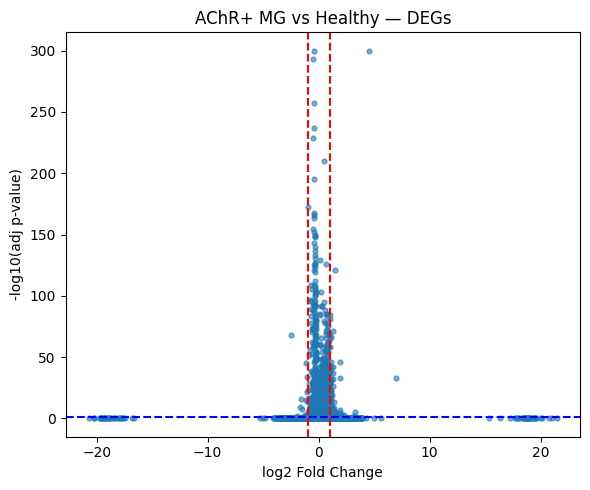

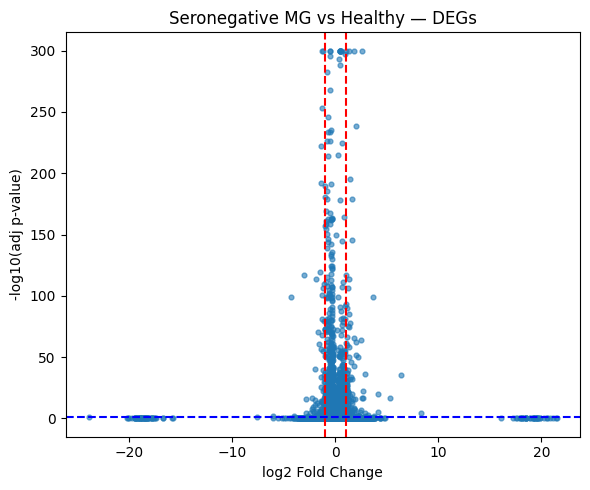

In [ ]:
def plot_volcano(df, title, save_path):
    plt.figure(figsize=(6,5))
    plt.scatter(
        df["logFC"],
        -np.log10(df["pvals_adj"] + 1e-300),
        s=12, alpha=0.6
    )
    plt.axvline(1, color="red", linestyle="--")
    plt.axvline(-1, color="red", linestyle="--")
    plt.axhline(-np.log10(0.05), color="blue", linestyle="--")

    plt.xlabel("log2 Fold Change")
    plt.ylabel("-log10(adj p-value)")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

plot_volcano(
    de_achr,
    "AChR+ MG vs Healthy — DEGs",
    "/content/drive/MyDrive/data_science_final_project/figures/PBMC_volcano_AChR.png"
)

plot_volcano(
    de_sero,
    "Seronegative MG vs Healthy — DEGs",
    "/content/drive/MyDrive/data_science_final_project/figures/PBMC_volcano_Sero.png"
)


In [ ]:
marker_genes = [
    "IL7R", "CCR7", "CD27",
    "NKG7", "GZMB", "PRF1",
    "S100A8", "S100A9", "LYZ",
    "MS4A1", "CD79A"
]

Present markers: ['IL7R', 'CCR7', 'CD27', 'NKG7', 'GZMB', 'PRF1', 'S100A8', 'S100A9', 'LYZ', 'MS4A1', 'CD79A']
Missing markers: []
Extra genes: ['AL627309.1', 'AL627309.5', 'AL669831.2', 'LINC01409', 'FAM87B', 'LINC01128', 'LINC00115', 'FAM41C', 'AL645608.2', 'SAMD11', 'NOC2L', 'KLHL17', 'PLEKHN1', 'AL645608.7', 'HES4', 'ISG15', 'AL645608.1', 'AGRN', 'C1orf159', 'AL390719.3', 'LINC01342', 'TTLL10', 'TNFRSF18', 'TNFRSF4', 'SDF4', 'B3GALT6', 'C1QTNF12', 'AL162741.1', 'UBE2J2', 'LINC01786', 'SCNN1D', 'ACAP3', 'PUSL1', 'INTS11', 'CPTP', 'TAS1R3', 'DVL1', 'MXRA8', 'AURKAIP1', 'CCNL2', 'MRPL20-AS1', 'MRPL20', 'AL391244.2', 'ANKRD65', 'ATAD3C', 'ATAD3B', 'ATAD3A', 'TMEM240', 'SSU72', 'AL645728.1', 'FNDC10', 'AL691432.4', 'AL691432.2', 'MIB2', 'MMP23B', 'CDK11B', 'FO704657.1', 'SLC35E2B', 'CDK11A', 'SLC35E2A', 'NADK', 'GNB1', 'AL109917.1', 'CALML6', 'TMEM52', 'CFAP74', 'GABRD', 'PRKCZ', 'AL590822.2', 'PRKCZ-AS1', 'FAAP20', 'SKI', 'AL590822.3', 'MORN1', 'AL513477.2', 'RER1', 'PEX10', 'PLCH2', '

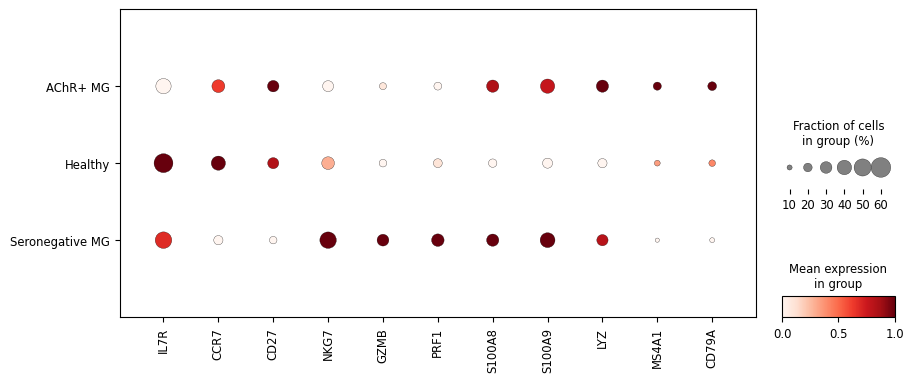

In [ ]:
# Filter the marker list to include only genes present in pbmc_de
present_markers = [g for g in marker_genes if g in pbmc_de.var_names]
missing_markers = [g for g in marker_genes if g not in pbmc_de.var_names]
extra_genes = [g for g in pbmc_de.var_names if g not in marker_genes]


print("Present markers:", present_markers)
print("Missing markers:", missing_markers)
print("Extra genes:", extra_genes)

# Plot only the present markers to avoid KeyError
sc.pl.dotplot(
    pbmc_de,
    var_names=present_markers,
    groupby="condition",
    standard_scale="var",
    figsize=(10,4),
    save="_PBMC_markers_by_condition_filtered.png"
)


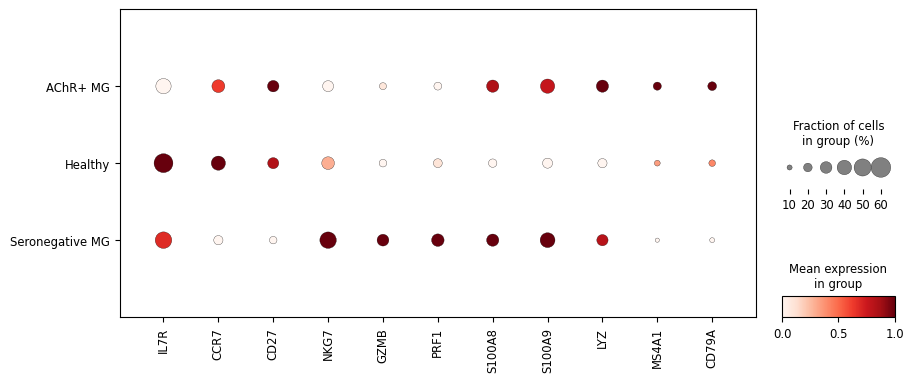

In [ ]:
sc.pl.dotplot(
    pbmc_de,
    var_names=marker_genes,
    groupby="condition",
    standard_scale="var",
    figsize=(10,4),
    save="_PBMC_markers_by_condition.png"
)


In [ ]:
print(pbmc.obs.columns)


Index(['sample_id', 'condition', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes',
       'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'leiden',
       'CD4 T_score', 'Cytotoxic T_score', 'B_score', 'Mono (CD14)_score',
       'Mono (FCGR3A)_score', 'DC_score', 'Platelet_score', 'cell_type',
       'cluster_celltype'],
      dtype='object')


In [ ]:
pbmc_de.obs["cell_type"] = pbmc.obs["cell_type"].copy()
pbmc_de.obs["cluster_celltype"] = pbmc.obs["cluster_celltype"].copy()
pbmc_de.obs["condition"] = pbmc.obs["condition"].copy()  # ensure consistency


In [ ]:
(pbmc_de.obs.index == pbmc.obs.index).all()

np.True_

/usr/local/lib/python3.12/dist-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[f"{value_to_plot}_colors"] = colors_list


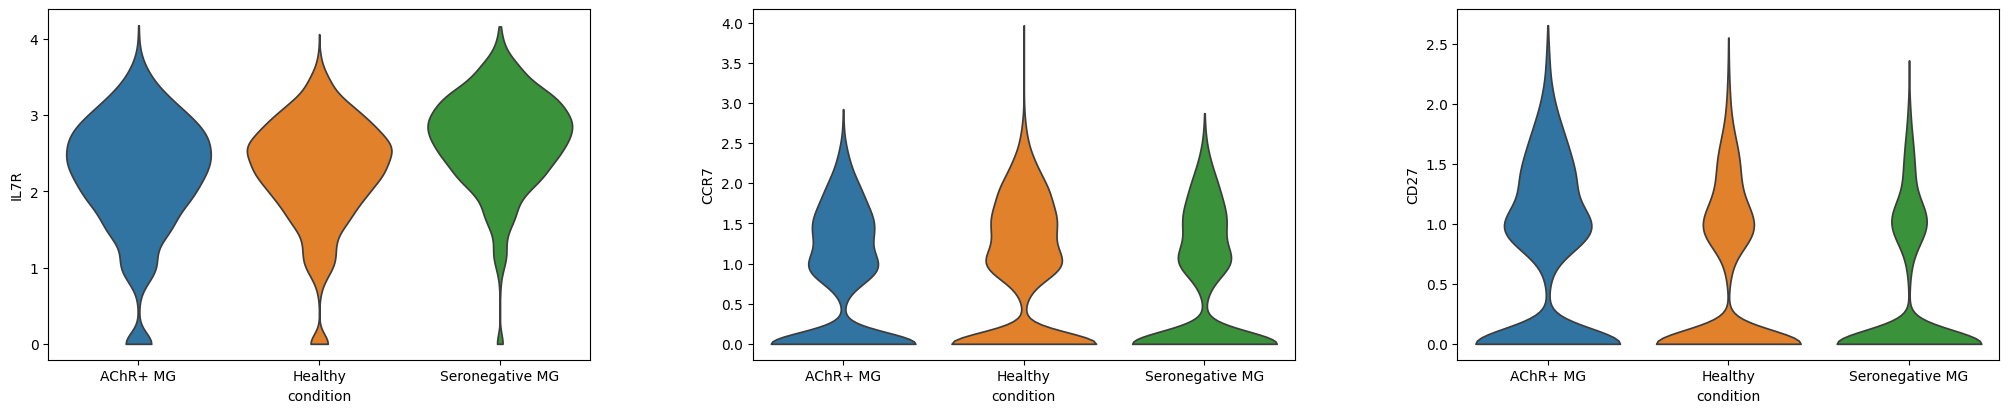

In [ ]:
cd4 = pbmc_de[pbmc_de.obs["cell_type"] == "CD4 T", :]

sc.pl.violin(
    cd4,
    keys=["IL7R", "CCR7", "CD27"],
    groupby="condition",
    stripplot=False,
    jitter=False,
    save="_PBMC_CD4T_activation_MG_vs_Healthy.png"
)

/usr/local/lib/python3.12/dist-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[f"{value_to_plot}_colors"] = colors_list


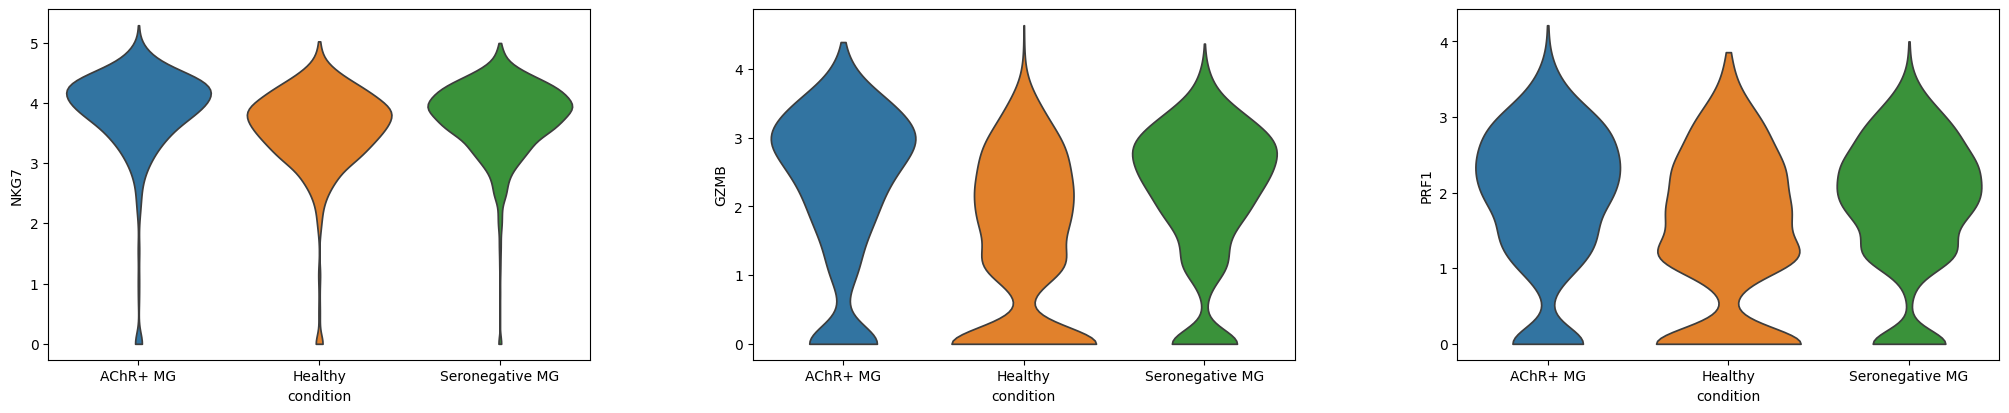

In [ ]:
cyto = pbmc_de[pbmc_de.obs["cell_type"] == "Cytotoxic T", :]
sc.pl.violin(
    cyto,
    keys=["NKG7", "GZMB", "PRF1"],
    groupby="condition",
    stripplot=False,
    save="_PBMC_Cytotoxic_markers.png"
)


/usr/local/lib/python3.12/dist-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[f"{value_to_plot}_colors"] = colors_list


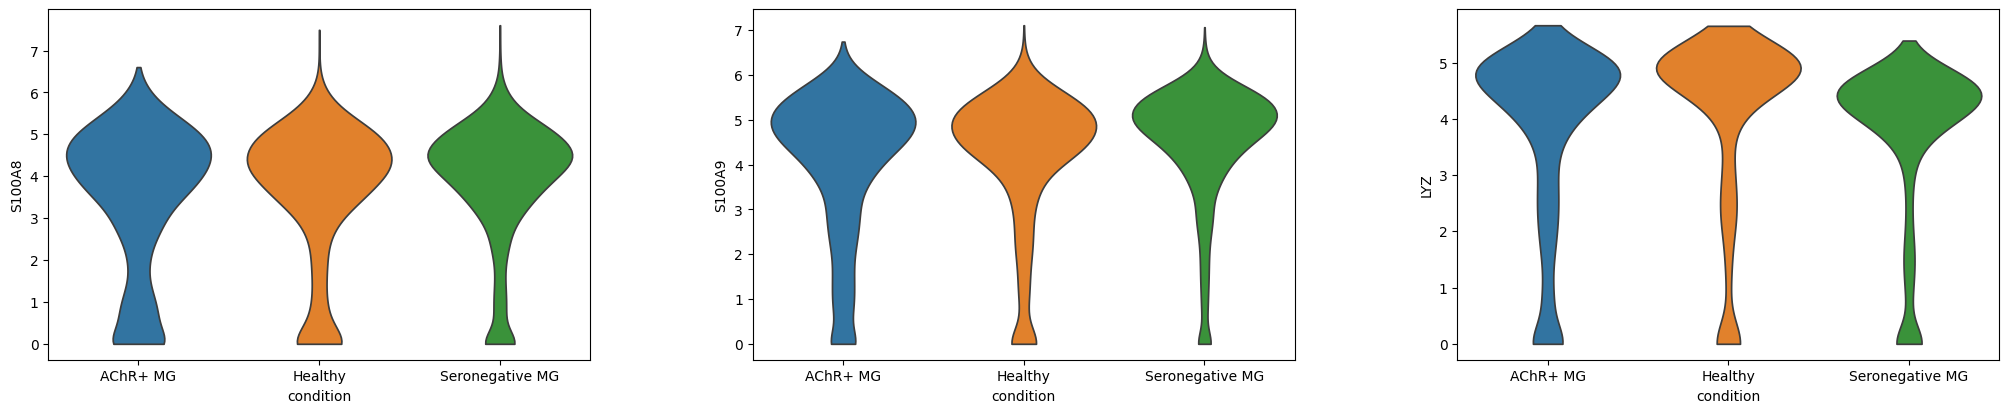

In [ ]:
mono = pbmc_de[pbmc_de.obs["cell_type"].isin(["Mono (CD14)", "Mono (FCGR3A)"]), :]

sc.pl.violin(
    mono,
    keys=["S100A8", "S100A9", "LYZ"],
    groupby="condition",
    stripplot=False,
    save="_PBMC_Monocyte_markers.png"
)


/usr/local/lib/python3.12/dist-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[f"{value_to_plot}_colors"] = colors_list


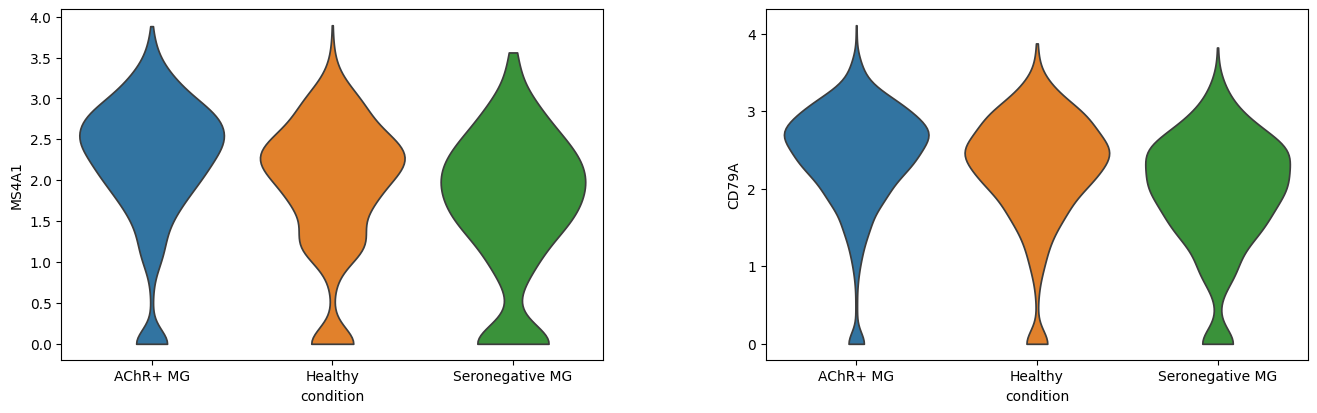

In [ ]:
b = pbmc_de[pbmc_de.obs["cell_type"] == "B", :]

sc.pl.violin(
    b,
    keys=["MS4A1", "CD79A"],
    groupby="condition",
    stripplot=False,
    save="_PBMC_Bcell_markers.png"
)


In [ ]:
pbmc_de.obsm["X_umap"] = pbmc.obsm["X_umap"]


In [ ]:
print("---------------------------------")
print(pbmc_de)
print("---------------------------------")
print(pbmc_de.obs.columns.tolist())
print("---------------------------------")

---------------------------------
AnnData object with n_obs × n_vars = 33615 × 21440
    obs: 'sample_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'CD4 T_score', 'Cytotoxic T_score', 'B_score', 'Mono (CD14)_score', 'Mono (FCGR3A)_score', 'DC_score', 'Platelet_score', 'cell_type', 'leiden', 'cluster_celltype'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'leiden', 'log1p', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
---------------------------------
['sample_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pc

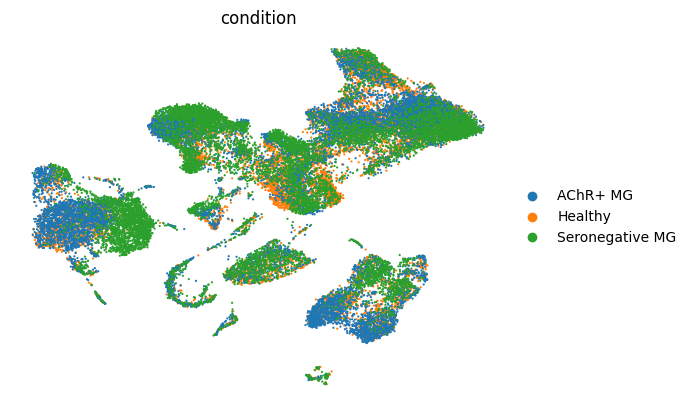

In [ ]:
sc.pl.umap(
    pbmc_de,
    color=["condition"],
    frameon=False,
    size=10,
    wspace=0.4,
    save="_PBMC_condition_umap.png"
)


In [ ]:
print(pbmc.obs["cell_type"].value_counts())
print(pbmc.obs["cluster_celltype"].value_counts())


cell_type
CD4 T            12626
Cytotoxic T       6921
Mono (CD14)       4856
B                 4224
Platelet          3338
Mono (FCGR3A)     1085
DC                 565
Name: count, dtype: int64
cluster_celltype
CD4 T            13400
Cytotoxic T       6706
Mono (CD14)       5296
B                 4170
Platelet          2975
Mono (FCGR3A)      602
DC                 466
Name: count, dtype: int64


pbmc_de: AnnData object with n_obs × n_vars = 33615 × 21440
    obs: 'sample_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'CD4 T_score', 'Cytotoxic T_score', 'B_score', 'Mono (CD14)_score', 'Mono (FCGR3A)_score', 'DC_score', 'Platelet_score', 'cell_type', 'leiden', 'cluster_celltype'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'leiden', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'condition_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
Conditions: condition
AChR+ MG           11456
Healthy            11401
Seronegative MG    10758
Name: count, dtype: int64
Cell types: cell_type
CD4 T     

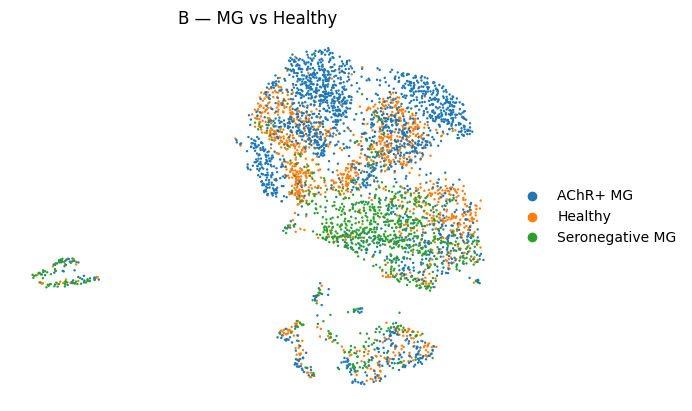

Processing CD4 T: 12626 cells


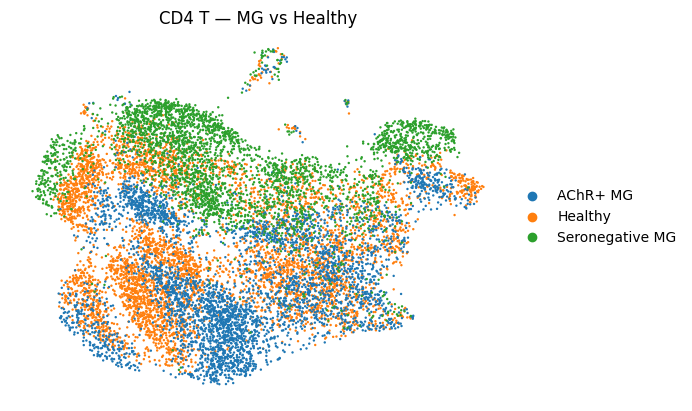

Processing Cytotoxic T: 6921 cells


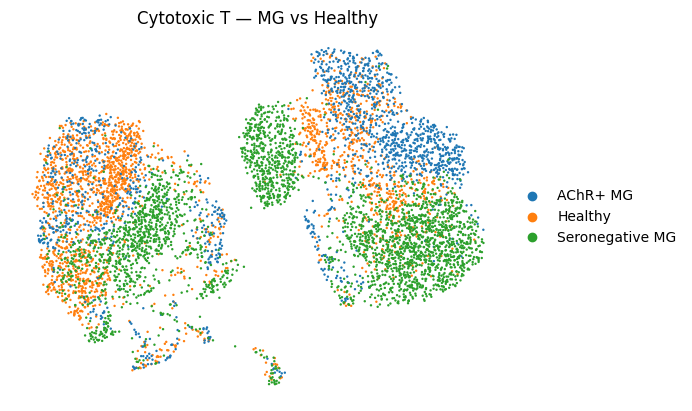

Processing DC: 565 cells


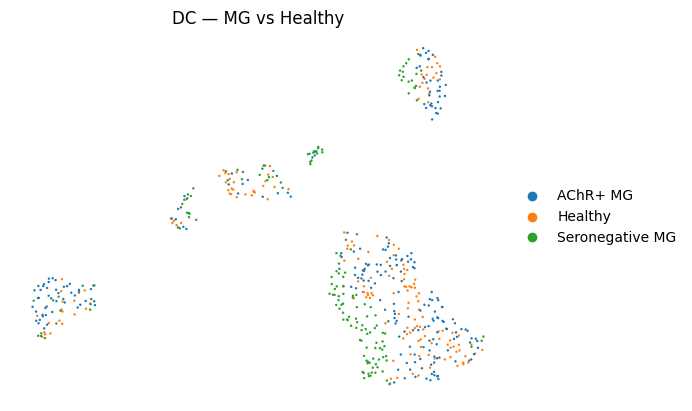

Processing Mono (CD14): 4856 cells


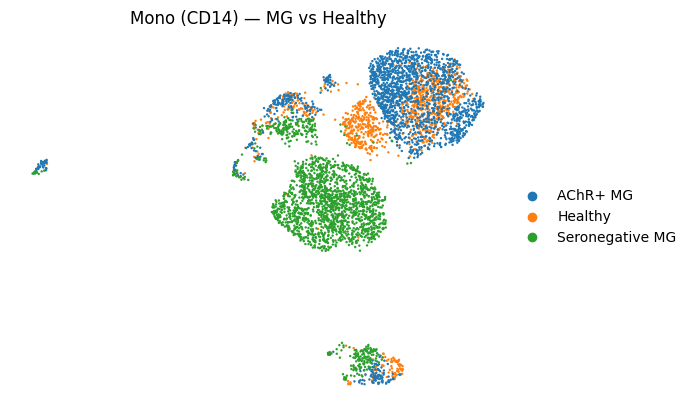

Processing Mono (FCGR3A): 1085 cells


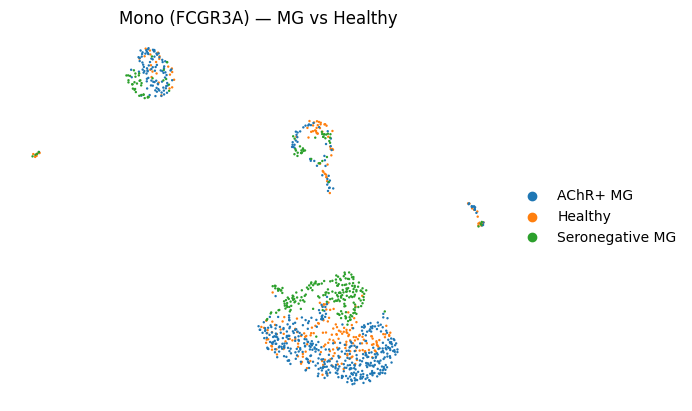

Processing Platelet: 3338 cells


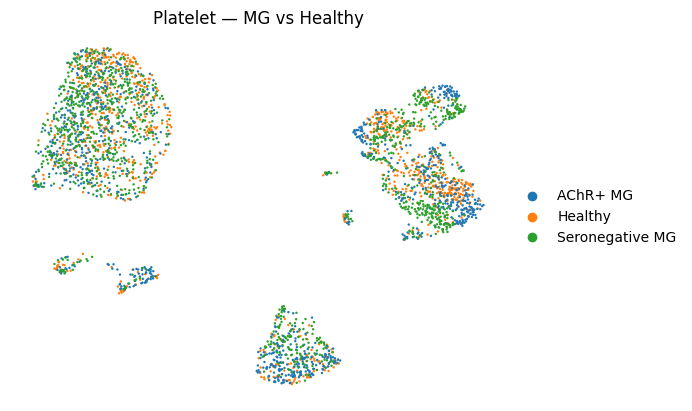

Done! All cell-type UMAPs saved.


In [ ]:

# PBMC MG vs Healthy — Cell-type–specific UMAP Analysis


import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1. Use the pbmc_de ALREADY IN MEMORY (do NOT reload)
# ------------------------------------------------------------
# pbmc_de = pbmc.copy()   <-- this should have been done earlier
# pbmc_de.obs["cell_type"] = pbmc.obs["cell_type"].copy()
# pbmc_de.obs["cluster_celltype"] = pbmc.obs["cluster_celltype"].copy()
# pbmc_de.obs["condition"] = pbmc.obs["condition"].copy()

print("pbmc_de:", pbmc_de)
print("Conditions:", pbmc_de.obs["condition"].value_counts())
print("Cell types:", pbmc_de.obs["cell_type"].value_counts())

# ------------------------------------------------------------
# 2. Copy UMAP coordinates from pbmc (scaled)
# ------------------------------------------------------------
pbmc_de.obsm["X_umap"] = pbmc.obsm["X_umap"].copy()

# ------------------------------------------------------------
# 3. Function to compute cell-type–specific UMAPs
# ------------------------------------------------------------
def plot_condition_umap_for_celltype(adata, cell_type, save_prefix="PBMC"):
    ct = adata[adata.obs["cell_type"] == cell_type].copy()

    if ct.n_obs < 50:
        print(f"Skipping {cell_type}: too few cells ({ct.n_obs})")
        return

    print(f"Processing {cell_type}: {ct.n_obs} cells")

    sc.pp.neighbors(ct)
    sc.tl.umap(ct)

    sc.pl.umap(
        ct,
        color="condition",
        title=f"{cell_type} — MG vs Healthy",
        frameon=False,
        size=12,
        save=f"_{save_prefix}_{cell_type.replace(' ', '_')}_condition.png"
    )

# ------------------------------------------------------------
# 4. Run UMAP MG vs Healthy for all PBMC lineages
# ------------------------------------------------------------
cell_types = sorted(pbmc_de.obs["cell_type"].unique().tolist())
print("Found cell types:", cell_types)

for ct in cell_types:
    plot_condition_umap_for_celltype(pbmc_de, ct, save_prefix="PBMC_lineage")

print("Done! All cell-type UMAPs saved.")


In [ ]:
save_dir = "/content/drive/MyDrive/data_science_final_project/data_processed"
save_path = f"{save_dir}/pbmc_DE_ready_annotated.h5ad"

pbmc_de.write(save_path)

In [ ]:
#-----------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#-----------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#-----------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#--------------------------------------------------------------------------- SCVI ---------------------------------------------------------------------------

In [ ]:
#-----------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#-----------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#-----------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:

# Load RAW PBMC QC Data for scVI


import scanpy as sc
import scvi

pbmc_raw_path = "/content/drive/MyDrive/data_science_final_project/data_processed/pbmc_qc.h5ad"

# Load the QC-only PBMC dataset (RAW COUNTS, no normalization, no HVG)
pbmc_scvi = sc.read_h5ad(pbmc_raw_path)

print(pbmc_scvi)
print("PBMC raw cell count:", pbmc.n_obs)
print("PBMC raw gene count:", pbmc.n_vars)

AnnData object with n_obs × n_vars = 33615 × 21440
    obs: 'sample_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
PBMC raw cell count: 33615
PBMC raw gene count: 2000


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training:   0%|          | 0/150 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
INFO: `Trainer.fit` stopped: `max_epochs=150` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.


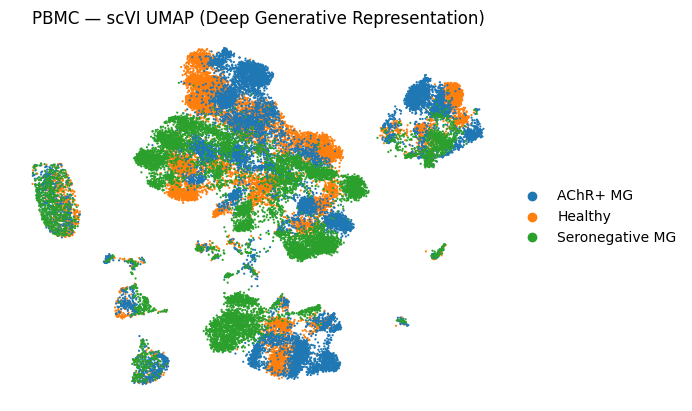

In [ ]:
import scvi

# ------------------------------------------------------------
# 1. Prepare a scVI-ready object with raw counts
# ------------------------------------------------------------
pbmc_scvi.layers["counts"] = pbmc_scvi.X.copy()   # scVI needs raw counts

# ------------------------------------------------------------
# 2. Setup scVI (NO batch_key — PBMC = representation learning)
# ------------------------------------------------------------
scvi.model.SCVI.setup_anndata(
    pbmc_scvi,
    layer="counts"
)

# ------------------------------------------------------------
# 3. Train scVI for 150 epochs (good for ~33k PBMC cells)
# ------------------------------------------------------------
model_pbmc = scvi.model.SCVI(pbmc_scvi, n_latent=20)

model_pbmc.train(
    max_epochs=150,
    check_val_every_n_epoch=10
)

# ------------------------------------------------------------
# 4. Save latent representation into .obsm
# ------------------------------------------------------------
pbmc_scvi.obsm["X_scVI"] = model_pbmc.get_latent_representation()

# ------------------------------------------------------------
# 5. Compute UMAP based on the scVI latent space
# ------------------------------------------------------------
sc.pp.neighbors(pbmc_scvi, use_rep="X_scVI")
sc.tl.umap(pbmc_scvi)

sc.pl.umap(
    pbmc_scvi,
    color=["condition"],
    frameon=False,
    size=10,
    title="PBMC — scVI UMAP (Deep Generative Representation)"
)

In [ ]:
save_path = "/content/drive/MyDrive/data_science_final_project/data_processed/pbmc_scvi_latent_umap.h5ad"
pbmc_scvi.write(save_path)

print("✓ Saved pbmc_scvi with scVI latent + UMAP to:", save_path)


✓ Saved pbmc_scvi with scVI latent + UMAP to: /content/drive/MyDrive/data_science_final_project/data_processed/pbmc_scvi_latent_umap.h5ad


In [ ]:
#-----------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#-----------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#-----------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#------------------------------------------------- can reload from there if needed ---------------------------------------------------------------------------

In [ ]:
#-----------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#-----------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#-----------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
load_path = "/content/drive/MyDrive/data_science_final_project/data_processed/pbmc_scvi_latent_umap.h5ad"

pbmc_scvi = sc.read_h5ad(load_path)

In [ ]:

# ANNOTATE PBMC BASED ON scVI LATENT SPACE


print("Running Leiden clustering on scVI latent space...")
sc.tl.leiden(pbmc_scvi, resolution=1.0, key_added="leiden_scvi")

# Marker genes
marker_dict = {
    "CD4 T"        : ["CD3E", "IL7R", "CCR7", "LTB"],
    "Cytotoxic T"  : ["CD3D", "NKG7", "GZMB", "GNLY", "PRF1"],
    "B"            : ["MS4A1", "CD79A", "CD79B"],
    "Mono (CD14)"  : ["LYZ", "S100A8", "S100A9", "CTSS"],
    "Mono (FCGR3A)": ["FCGR3A", "MS4A7", "LYZ"],
    "DC"           : ["FCER1A", "CST3"],
    "Platelet"     : ["PPBP", "PF4"],
}

# Filter to genes present
marker_dict_filtered = {
    ct: [g for g in genes if g in pbmc_scvi.var_names]
    for ct, genes in marker_dict.items()
}

# Compute marker scores per-cell
for ct, genes in marker_dict_filtered.items():
    sc.tl.score_genes(pbmc_scvi, gene_list=genes, score_name=f"{ct}_score")

# Assign best cell type based on max marker score
score_cols = [f"{ct}_score" for ct in marker_dict_filtered.keys()]
pbmc_scvi.obs["cell_type"] = (
    pbmc_scvi.obs[score_cols]
    .idxmax(axis=1)
    .str.replace("_score", "", regex=False)
)

# Majority-vote cluster labels in scVI space
cluster_labels = (
    pbmc_scvi.obs.groupby("leiden_scvi")["cell_type"]
    .agg(lambda x: x.value_counts().index[0])
)

pbmc_scvi.obs["cluster_celltype"] = pbmc_scvi.obs["leiden_scvi"].map(cluster_labels)

print("Annotation complete:")
print(pbmc_scvi.obs["cell_type"].value_counts())
print(pbmc_scvi.obs["cluster_celltype"].value_counts())


Running Leiden clustering on scVI latent space...
Annotation complete:
cell_type
CD4 T            14563
Cytotoxic T       6626
Mono (CD14)       5423
B                 3400
Platelet          2188
DC                 992
Mono (FCGR3A)      423
Name: count, dtype: int64
cluster_celltype
CD4 T          14947
Cytotoxic T     6487
Mono (CD14)     5802
B               3798
Platelet        1473
DC              1108
Name: count, dtype: int64


/tmp/ipython-input-2546803364.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pbmc_scvi.obs.groupby("leiden_scvi")["cell_type"]


In [ ]:
print("---------------------------------")
print(pbmc_scvi)
print("---------------------------------")
print(pbmc_scvi.obs.columns.tolist())
print("---------------------------------")

---------------------------------
AnnData object with n_obs × n_vars = 33615 × 21440
    obs: 'sample_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', 'leiden_scvi', 'CD4 T_score', 'Cytotoxic T_score', 'B_score', 'Mono (CD14)_score', 'Mono (FCGR3A)_score', 'DC_score', 'Platelet_score', 'cell_type', 'cluster_celltype'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'condition_colors', 'neighbors', 'umap', 'leiden_scvi'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'
---------------------------------
['sample_id', 'condition', 'n_genes_by_cou

In [ ]:

# CHECK THAT ANNOTATIONS EXIST BEFORE SAVING

print("\n=== Annotation Check ===")
print("cell_type exists:", "cell_type" in pbmc_scvi.obs.columns)
print("cluster_celltype exists:", "cluster_celltype" in pbmc_scvi.obs.columns)
print("Columns:", pbmc_scvi.obs.columns.tolist())


=== Annotation Check ===
cell_type exists: True
cluster_celltype exists: True
Columns: ['sample_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', 'leiden_scvi', 'CD4 T_score', 'Cytotoxic T_score', 'B_score', 'Mono (CD14)_score', 'Mono (FCGR3A)_score', 'DC_score', 'Platelet_score', 'cell_type', 'cluster_celltype']


In [ ]:

# SAVE PCA-ANNOTATED PBMC OBJECT


annotated_pca_path = (
    "/content/drive/MyDrive/data_science_final_project/data_processed/"
    "pbmc_scvi_annotated.h5ad"
)

pbmc_scvi.write(annotated_pca_path)

In [ ]:
#-----------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#-----------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#-----------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#------------------------------------------------- can reload from there if needed ---------------------------------------------------------------------------

In [ ]:
#-----------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#-----------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#-----------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
annotated_pca_path = (
    "/content/drive/MyDrive/data_science_final_project/data_processed/"
    "pbmc_scvi_annotated.h5ad"
)

pbmc_scvi = sc.read_h5ad(annotated_pca_path)

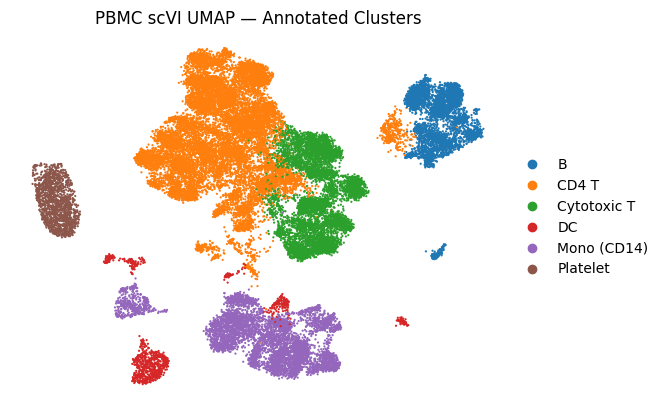

In [ ]:

# Visualize annotated scVI UMAP
sc.pl.umap(
    pbmc_scvi,
    color=["cluster_celltype"],
    size=10,
    frameon=False,
    title="PBMC scVI UMAP — Annotated Clusters"
)

In [ ]:

# COPY CELL-TYPE ANNOTATION FROM PCA OBJECT INTO scVI OBJECT


# Load annotated PCA object
#pca_path = "/content/drive/MyDrive/data_science_final_project/data_processed/pbmc_PCA_annotated.h5ad"
#pbmc_pca = sc.read_h5ad(pca_path)

#print("Copying annotations from PCA → scVI...")

# Columns to copy
#cols_to_copy = ["cell_type", "cluster_celltype", "condition"]

#for col in cols_to_copy:
    #pbmc_scvi.obs[col] = pbmc_pca.obs[col].copy()

#print("✓ Annotation added: cell_type, cluster_celltype, condition")


In [ ]:
#sc.pp.neighbors(pbmc_scvi, use_rep="X_scVI")
#sc.tl.umap(pbmc_scvi)


In [ ]:
#sc.pl.umap(
    #pbmc_scvi,
    #color="cell_type",
    #frameon=False,
    #size=10,
    #title="PBMC — scVI UMAP (Cell Types)"
#)


In [ ]:
#!rm -rf /content/drive

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

In [ ]:
!ls /content/drive/MyDrive


'Colab Notebooks'   data_science_final_project


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ------------------------------------------------------------
# 6. Save scVI PBMC object
# ------------------------------------------------------------
#pbmc_scvi.write("/content/drive/MyDrive/data_science_final_project/data_processed/pbmc_scVI_representation.h5ad")

#print("\nSaved PBMC scVI representation object.")


In [ ]:

# RE-ANNOTATE PCA OBJECT (because saved file has no annotations)


#import scanpy as sc
#import pandas as pd

#print("Reloading PCA object for re-annotation...")

#pca_path = "/content/drive/MyDrive/data_science_final_project/data_processed/pbmc_PCA_representation.h5ad"
#pbmc = sc.read_h5ad(pca_path)

#print("Loaded PCA object.")
#print("Current .obs columns:", pbmc.obs.columns.tolist())

# ------------------------------------------------------------
# MARKER SET (same as your notebook)
# ------------------------------------------------------------
#marker_dict = {
#    "CD4 T"        : ["CD3E", "IL7R", "CCR7", "LTB"],
#    "Cytotoxic T"  : ["CD3D", "NKG7", "GZMB", "GNLY", "PRF1"],
#    "B"            : ["MS4A1", "CD79A", "CD79B"],
#    "Mono (CD14)"  : ["LYZ", "S100A8", "S100A9", "CTSS"],
#    "Mono (FCGR3A)": ["FCGR3A", "MS4A7", "LYZ"],
#    "DC"           : ["FCER1A", "CST3"],
#    "Platelet"     : ["PPBP", "PF4"],
#}

## Filter markers to HVGs present
#marker_dict_filtered = {}
#for ct, genes in marker_dict.items():
#    present = [g for g in genes if g in pbmc.var_names]
#    if present:
#        marker_dict_filtered[ct] = present

#print("Filtered markers:", marker_dict_filtered)

# ------------------------------------------------------------
# SCORE GENES
# ------------------------------------------------------------
#for ct, genes in marker_dict_filtered.items():
#    sc.tl.score_genes(
#        pbmc,
#        gene_list=genes,
#        score_name=f"{ct}_score",
#        use_raw=False
#    )

#score_cols = [f"{ct}_score" for ct in marker_dict_filtered]

# ------------------------------------------------------------
# PER-CELL TYPE ASSIGNMENT
# ------------------------------------------------------------
#pbmc.obs["cell_type"] = (
#    pbmc.obs[score_cols]
#    .idxmax(axis=1)
#    .str.replace("_score", "", regex=False)
#)

#print("\nPer-cell annotation complete.")
#print(pbmc.obs["cell_type"].value_counts())

# ------------------------------------------------------------
# CLUSTER-LEVEL LABELS (majority vote)
# ------------------------------------------------------------
#cluster_labels = (
#    pbmc.obs.groupby("leiden")["cell_type"]
#    .agg(lambda x: x.value_counts().index[0])
#)

#pbmc.obs["cluster_celltype"] = pbmc.obs["leiden"].map(cluster_labels)

#print("\nCluster-level annotation:")
#print(cluster_labels)

# ------------------------------------------------------------
# SAVE UPDATED PCA OBJECT
# ------------------------------------------------------------
#pbmc.write(pca_path)
#print("\nPCA object re-annotated and saved.")
#print("Now it contains:", pbmc.obs.columns.tolist())


In [ ]:
#import scanpy as sc

#pca_path = "/content/drive/MyDrive/data_science_final_project/data_processed/pbmc_PCA_representation.h5ad"
#pbmc_test = sc.read_h5ad(pca_path)

#print("Loaded PCA object.")
#print("Columns in .obs:")
#print(pbmc_test.obs.columns.tolist())

#print("\nNumber of unique cell types (if exists):")
#print(pbmc_test.obs.get("cell_type", "cell_type NOT FOUND"))


In [ ]:
#import scanpy as sc

#scvi_path = "/content/drive/MyDrive/data_science_final_project/data_processed/pbmc_scVI_representation.h5ad"
#pbmc_scvi = sc.read_h5ad(scvi_path)

#print(pbmc_scvi.obs.columns.tolist())


In [ ]:
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#---------------------------------------------- can reload from here ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Running PBMC representation metrics...
Loaded PCA + scVI objects
pca silhouette computed

===== Silhouette Score (Cell Type) =====
PCA  silhouette(cell type):  0.2662
scVI silhouette(cell type): 0.1417

===== Silhouette Score (Condition) =====
Note: this metric is for interpretation, NOT optimization.
PCA  silhouette(condition):  -0.0150
scVI silhouette(condition): 0.0244


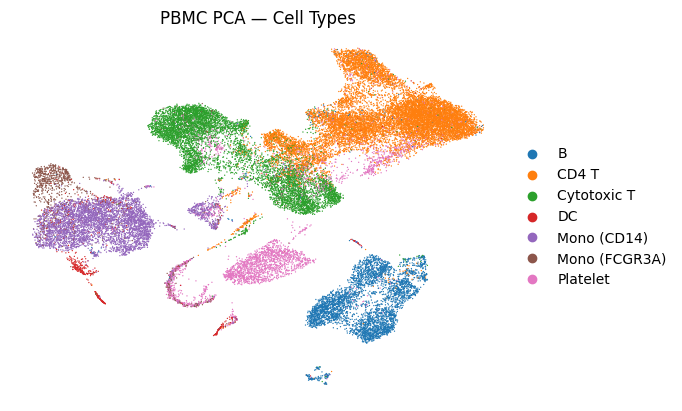

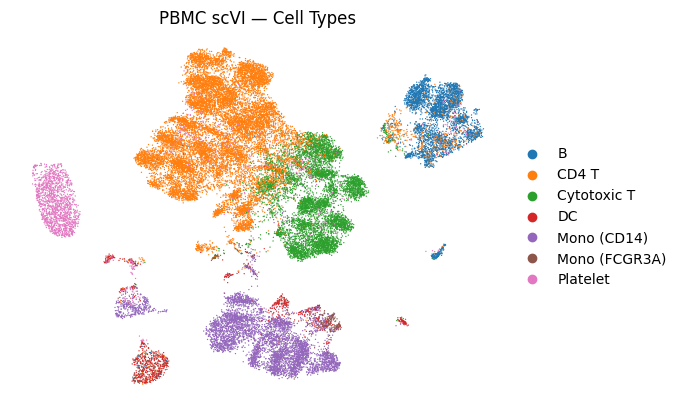

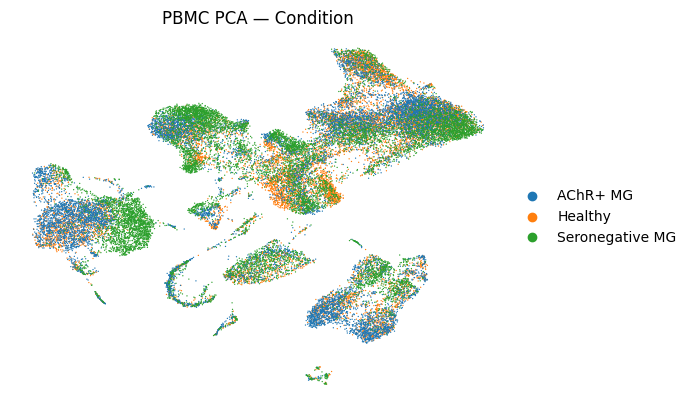

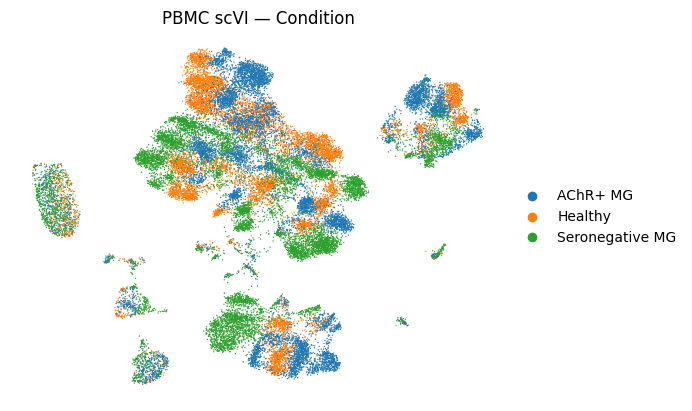


PBMC representation metrics completed.


In [ ]:

# PBMC Representation Learning Metrics (PCA vs scVI)


import scanpy as sc
from sklearn.metrics import silhouette_score
import numpy as np

print("Running PBMC representation metrics...")

# ------------------------------------------------------------
# LOAD THE SAVED PCA + scVI REPRESENTATIONS
# ------------------------------------------------------------
pbmc = sc.read_h5ad("/content/drive/MyDrive/data_science_final_project/data_processed/pbmc_PCA_annotated.h5ad")
pbmc_scvi = sc.read_h5ad("/content/drive/MyDrive/data_science_final_project/data_processed/pbmc_scvi_annotated.h5ad")

print("Loaded PCA + scVI objects")

# ------------------------------------------------------------
# 1. Silhouette Score — Cell Type  (MAIN METRIC)
# ------------------------------------------------------------
sil_pca_cell = silhouette_score(pbmc.obsm["X_pca"], pbmc.obs["cell_type"])
print("pca silhouette computed")
sil_scvi_cell = silhouette_score(pbmc_scvi.obsm["X_scVI"], pbmc_scvi.obs["cell_type"])

print("\n===== Silhouette Score (Cell Type) =====")
print(f"PCA  silhouette(cell type):  {sil_pca_cell:.4f}")
print(f"scVI silhouette(cell type): {sil_scvi_cell:.4f}")

# ------------------------------------------------------------
# 2. Silhouette Score — Condition  (Interpretation only)
# ------------------------------------------------------------
sil_pca_cond = silhouette_score(pbmc.obsm["X_pca"], pbmc.obs["condition"])
sil_scvi_cond = silhouette_score(pbmc_scvi.obsm["X_scVI"], pbmc_scvi.obs["condition"])

print("\n===== Silhouette Score (Condition) =====")
print("Note: this metric is for interpretation, NOT optimization.")
print(f"PCA  silhouette(condition):  {sil_pca_cond:.4f}")
print(f"scVI silhouette(condition): {sil_scvi_cond:.4f}")

# ------------------------------------------------------------
# 3. Optional: Visual confirmation via side-by-side UMAPs
# ------------------------------------------------------------
sc.pl.umap(pbmc, color="cell_type", title="PBMC PCA — Cell Types", frameon=False)
sc.pl.umap(pbmc_scvi, color="cell_type", title="PBMC scVI — Cell Types", frameon=False)

sc.pl.umap(pbmc, color="condition", title="PBMC PCA — Condition", frameon=False)
sc.pl.umap(pbmc_scvi, color="condition", title="PBMC scVI — Condition", frameon=False)

print("\nPBMC representation metrics completed.")


In [ ]:

# SAVE PBMC METRICS TO CSV


import pandas as pd
import os

# 1. Create directory for metrics
metrics_dir = "/content/drive/MyDrive/data_science_final_project/metrics/pbmc"
os.makedirs(metrics_dir, exist_ok=True)

# 2. Create metrics table
metrics = {
    "metric": [
        "silhouette_cell_type_PCA",
        "silhouette_cell_type_scVI",
        "silhouette_condition_PCA",
        "silhouette_condition_scVI",
    ],
    "value": [
        sil_pca_cell,
        sil_scvi_cell,
        sil_pca_cond,
        sil_scvi_cond,
    ],
}

df_metrics = pd.DataFrame(metrics)

# 3. Save CSV
save_path = f"{metrics_dir}/pbmc_representation_metrics.csv"
df_metrics.to_csv(save_path, index=False)

print("\n✓ Saved PBMC representation metrics to:")
print(save_path)



✓ Saved PBMC representation metrics to:
/content/drive/MyDrive/data_science_final_project/metrics/pbmc/pbmc_representation_metrics.csv


In [ ]:
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#---------------------------------------------- can reload from here ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:

# PBMC REPRESENTATION METRICS — FULL SUITE

import scanpy as sc
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import KMeans

# ------------------------------
# LOAD PCA + scVI REPRESENTATIONS
# ------------------------------
pbmc_pca = sc.read_h5ad("/content/drive/MyDrive/data_science_final_project/data_processed/pbmc_PCA_annotated.h5ad")
pbmc_scvi = sc.read_h5ad("/content/drive/MyDrive/data_science_final_project/data_processed/pbmc_scvi_annotated.h5ad")

print("Loaded PCA + scVI PBMC datasets.")


Loaded PCA + scVI PBMC datasets.


In [ ]:

# 1. SILHOUETTE (CELL TYPE and CONDITION)

sil_ct_pca = silhouette_score(pbmc_pca.obsm["X_pca"], pbmc_pca.obs["cell_type"])
sil_ct_scvi = silhouette_score(pbmc_scvi.obsm["X_scVI"], pbmc_scvi.obs["cell_type"])

sil_cond_pca = silhouette_score(pbmc_pca.obsm["X_pca"], pbmc_pca.obs["condition"])
sil_cond_scvi = silhouette_score(pbmc_scvi.obsm["X_scVI"], pbmc_scvi.obs["condition"])

print("\n===== SILHOUETTE SCORES =====")
print(f"PCA   Silhouette (cell_type): {sil_ct_pca:.4f}")
print(f"scVI  Silhouette (cell_type): {sil_ct_scvi:.4f}")
print(f"PCA   Silhouette (condition): {sil_cond_pca:.4f}")
print(f"scVI  Silhouette (condition): {sil_cond_scvi:.4f}")


===== SILHOUETTE SCORES =====
PCA   Silhouette (cell_type): 0.2662
scVI  Silhouette (cell_type): 0.1417
PCA   Silhouette (condition): -0.0150
scVI  Silhouette (condition): 0.0244


In [ ]:
print(pbmc_pca.obs.columns.tolist())
print(pbmc_scvi.obs.columns.tolist())

['sample_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'leiden', 'CD4 T_score', 'Cytotoxic T_score', 'B_score', 'Mono (CD14)_score', 'Mono (FCGR3A)_score', 'DC_score', 'Platelet_score', 'cell_type', 'cluster_celltype']
['sample_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', 'leiden_scvi', 'CD4 T_score', 'Cytotoxic T_score', 'B_score', 'Mono (CD14)_score', 'Mono (FCGR3A)_score', 'DC_score', 'Platelet_score', 'cell_type', 'cluster_celltype']


In [ ]:
print(pbmc_pca.uns.keys())
print(pbmc_pca.obsp.keys())

dict_keys(['cluster_celltype_colors', 'condition_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'])
KeysView(PairwiseArrays with keys: connectivities, distances)


In [ ]:

# 2. ARI / NMI AGAINST TRUE CELL TYPES

# Use Leiden clusters for PCA and scVI as predicted labels
pca_clusters = pbmc_pca.obs["leiden"].astype(str)
scvi_clusters = pbmc_scvi.obs["leiden_scvi"].astype(str)
true_labels = pbmc_pca.obs["cell_type"].astype(str)

ari_pca = adjusted_rand_score(true_labels, pca_clusters)
nmi_pca = normalized_mutual_info_score(true_labels, pca_clusters)

ari_scvi = adjusted_rand_score(true_labels, scvi_clusters)
nmi_scvi = normalized_mutual_info_score(true_labels, scvi_clusters)

print("\n===== ARI / NMI (vs true cell types) =====")
print(f"PCA   ARI: {ari_pca:.4f}   NMI: {nmi_pca:.4f}")
print(f"scVI  ARI: {ari_scvi:.4f}   NMI: {nmi_scvi:.4f}")


===== ARI / NMI (vs true cell types) =====
PCA   ARI: 0.3532   NMI: 0.5699
scVI  ARI: 0.1984   NMI: 0.5047


In [ ]:

# 3. KMEANS CLUSTERING CONSISTENCY

def kmeans_score(embedding, labels, k=10):
    km = KMeans(n_clusters=k, random_state=0).fit(embedding)
    pred = km.labels_
    return adjusted_rand_score(labels, pred), normalized_mutual_info_score(labels, pred)

kmeans_ari_pca, kmeans_nmi_pca = kmeans_score(pbmc_pca.obsm["X_pca"], true_labels)
kmeans_ari_scvi, kmeans_nmi_scvi = kmeans_score(pbmc_scvi.obsm["X_scVI"], true_labels)

print("\n===== KMEANS CLUSTER AGREEMENT =====")
print(f"PCA   KMeans ARI: {kmeans_ari_pca:.4f}   NMI: {kmeans_nmi_pca:.4f}")
print(f"scVI  KMeans ARI: {kmeans_ari_scvi:.4f}   NMI: {kmeans_nmi_scvi:.4f}")


# 4. NEIGHBORHOOD OVERLAP (STRUCTURE COMPARISON PCA vs scVI)

from sklearn.neighbors import NearestNeighbors

def neighbor_overlap(X1, X2, k=15):
    nn1 = NearestNeighbors(n_neighbors=k).fit(X1)
    nn2 = NearestNeighbors(n_neighbors=k).fit(X2)
    n1 = nn1.kneighbors(return_distance=False)
    n2 = nn2.kneighbors(return_distance=False)
    overlaps = [len(set(a).intersection(set(b))) / k for a, b in zip(n1, n2)]
    return np.mean(overlaps)

overlap_score = neighbor_overlap(pbmc_pca.obsm["X_pca"], pbmc_scvi.obsm["X_scVI"])

print("\n===== PCA vs scVI STRUCTURE OVERLAP =====")
print(f"Average neighborhood overlap: {overlap_score:.4f}")



===== KMEANS CLUSTER AGREEMENT =====
PCA   KMeans ARI: 0.6225   NMI: 0.6324
scVI  KMeans ARI: 0.4284   NMI: 0.5818

===== PCA vs scVI STRUCTURE OVERLAP =====
Average neighborhood overlap: 0.0711


In [ ]:

# SAVE ALL PBMC REPRESENTATION METRICS TO CSV


import os

metrics_dir = "/content/drive/MyDrive/data_science_final_project/metrics/pbmc"
os.makedirs(metrics_dir, exist_ok=True)

metrics = {
    "metric": [
        "silhouette_cell_type_PCA",
        "silhouette_cell_type_scVI",
        "silhouette_condition_PCA",
        "silhouette_condition_scVI",
        "ARI_PCA_vs_celltype",
        "NMI_PCA_vs_celltype",
        "ARI_scVI_vs_celltype",
        "NMI_scVI_vs_celltype",
        "KMeans_ARI_PCA",
        "KMeans_NMI_PCA",
        "KMeans_ARI_scVI",
        "KMeans_NMI_scVI",
        "Neighborhood_overlap_PCA_scVI"
    ],
    "value": [
        sil_ct_pca,
        sil_ct_scvi,
        sil_cond_pca,
        sil_cond_scvi,
        ari_pca,
        nmi_pca,
        ari_scvi,
        nmi_scvi,
        kmeans_ari_pca,
        kmeans_nmi_pca,
        kmeans_ari_scvi,
        kmeans_nmi_scvi,
        overlap_score
    ]
}

df_metrics = pd.DataFrame(metrics)

save_path = f"{metrics_dir}/pbmc_full_representation_metrics.csv"
df_metrics.to_csv(save_path, index=False)

print("\n✓ Saved FULL PBMC representation metrics to:")
print(save_path)



✓ Saved FULL PBMC representation metrics to:
/content/drive/MyDrive/data_science_final_project/metrics/pbmc/pbmc_full_representation_metrics.csv


In [ ]:
from google.colab import files
files.download("/content/drive/MyDrive/data_science_final_project/metrics/pbmc/pbmc_full_representation_metrics.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>